# <b>Project Definition</b>

### <b>Domain Background</b>

In the field of instrumental analytical chemistry, there are many techniques for identifying unknown substances. This field is primarily researched for the detection of explosives, drugs and chemical weapons, however, there are many other applications for it. In the healthcare field, researchers are using it to detect cancer and diseases.
Chromatography is a method by which a substance is separated into different components and split across time. For example, if you sample a mixture that is made up of multiple substances you could separate those substances and detect them individually with chromatography. One method of chromatography is using what is called a column. This device is what will separate out the components of a mixture, however, it is extremely slow. It takes minutes to work.

Mass spectrometry is the technique of identifying the chemical structure of a substance by separating ions into differing mass and charge. The three essential components of a mass spectrometer are the ion source, the mass analyzer, and the detector. The ionizer ionizes the sampled substance. The analyzer sorts and separates the ions by mass and charge. The detector measures or counts the separated ions. Ions can be displayed as a histogram of mass-to-charge ratio(m/z) or can be displayed across time to see line curves where the peaks would be where the max quantity of ions were detected. There are many different techniques for each component in performing the identification of substances.


The most popular analytical technique today is ion-mobility spectrometry (IMS). This technique separates and identifies ionized molecules based on their mobility within a carrier gas. It is extremely fast and takes milliseconds to achieve a result, but it is less sensitive than other techniques. This technique is very popular because you can make an IMS device for relative low cost compared to other techniques and the device can be small enough to be hand-held.

The final technique that we will discuss is triple quadrupole mass spectrometry (TQMS). This is a tandem mass spectrometry technique, which just means it has two analyzers. The components in order are the ion source, a quadrupole mass analyzer, a quadrupole that acts as a collision cell to fragment the molecules entering it, a second analyzer that analyzes the resulting fragments, and finally the detector. The quadrupole works by creating an electro-magnetic field that separates the ions and makes them follow a trajectory based on their mass-to-charge ratio (m/z). This technique in theory is the most sensitive and will achieve results in seconds. These devices tend to be very expensive and large. This is the device a team and I are working on.

The above techniques discussed can all be combined to solve problems depending on the application. There are trade-offs that must be made for each technique. Cost and weight are always a major factor. In some cases, the science is not well understood.

### Problem Statement

My team and I are currently working on a triple quad mass spectrometer that is cheaper and smaller so that we can address new markets and applications that TQMS was unable to address previously. Our current instrument displays mass-to-charge ratios over time. We have in the past used peak thresholds to determine what is a detected substance. This technique only gives us an accuracy of 40% with a very high rate of false positives. We are trying to achieve an accuracy of 90% with no more than a 2% false positive rate. We have talked about adding some filtering techniques, but there will be a tradeoff in time and cost. We need to complete our analysis in under 10 seconds. Ideally, we can solve our problem with purely algorithms.

### Data sets and Input

The datasets that will be used in this project were generated from collected samples from our instrument. The instrument was sent out for testing and 12 different substances were tested. The data files we got back are the results from that testing. The datasets are generated from these data files. The datasets have been modified to abstract out any sensitive details such as the substance name and mass pairs. Most importantly the intensities are all generated to mimic the shape of the collected data. The data has also been filtered to remove any malformed data because of a hardware or any other error. There is no proprietary data associated with this project. The model that will be built will need to be re-trained on the actual proprietary dataset to have it work with our instrument. The generated data should be more than adequate in evaluating a model. In most cases, I have between 50 and 80 samples for each substance I am testing for. I realize that this may not be enough, but I am also trying to gauge how many samples will be needed if extending out the substance library. If a compound is performing poorly from lack of samples I will remove it from the test.

Each data file consists of multiple components. First, there will be a mass pair transition id. A mass pair transition consists of an ion charge (+ or -), parent mass, a daughter mass, and collision energy i.e. +123->456(78). The ion charge is from the ion source, the parent mass is from the first quad, the daughter mass is from the third quad and the collision energy is applied at the second quad. Instead of seeing this transition you will see a number 0 to n-1 where n is the total quantity of specified transitions (i.e. n=51). After the id there will be a sample id associated to the dataset, a comment field which will specify if another substance was combined the tested for substance, and what substrate it was sampled on. Substrate could have the value direct, or a harvest code like Perf5. Direct means the substance was inserted into the instrument through a syringe. Direct should be the most stable result. If the substance was harvested off material Perf5 that means the substance was applied to the material and then swiped off with one of our swabs. Theoretically when a substance is harvested it should measure lower ions than direct because you may not of collected the entire amount of the substance. After the substrate field, there will be detection field and an association field. The detection field will have an array of numbers specifying what compounds are detected within that dataset. The association field will specify what mass pairs are associated to which compounds according to our chemist, for example mass pair 1 is associated to compounds [1,3]. After the associated field there will be a height, width, area, and position of the mass pair peak. These values are acquired by applying a smoothing filter to reduce the noise of the signal. Finally, there will be a time series of intensities over a specified number of time steps or scans (i.e. 23). For now, the scan count is fixed to 23, however, in the future it would be better to have scan count be variable in case we want to stop early. So, for each data file you would have that structure per row times the amount of transitions for example 51x33.

In [1]:
# Install required packages in the current Jupyter kernel
import sys
#Used with Anaconda 64
!"{sys.executable}" -m pip install -U pip
!"{sys.executable}" -m pip install -U matplotlib

  Using cached https://files.pythonhosted.org/packages/5c/e0/be401c003291b56efc55aeba6a80ab790d3d4cece2778288d65323009420/pip-19.1.1-py2.py3-none-any.whl
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1


distributed 1.21.8 requires msgpack, which is not installed.


  Using cached https://files.pythonhosted.org/packages/cc/eb/fd7a5f3c1484e8d2590ff94ca0b89941940a916394f719ab3bb7279e1970/matplotlib-3.1.1-cp36-cp36m-win_amd64.whl
  Found existing installation: matplotlib 2.2.2
    Uninstalling matplotlib-2.2.2:
      Successfully uninstalled matplotlib-2.2.2


In [2]:
#Load datasets
import pandas as pd
import glob, os

os.chdir("./data")

samples = []
count = 0
max_mass_pair_count = 0
for file in glob.glob("*.csv"):
    data_frame = pd.read_csv(file)
    count += 1
    mass_pair_count = len(data_frame)
    max_mass_pair_count = mass_pair_count if mass_pair_count > max_mass_pair_count else max_mass_pair_count
    samples.append(data_frame)
    
os.chdir("..")

merged_data_set = pd.concat(samples, ignore_index=True)

print("Number of Samples: ", count)
print("Max number of mass pairs: ", max_mass_pair_count)


Number of Samples:  641
Max number of mass pairs:  51


In [3]:
#multi detection
display(merged_data_set.head(1))
#single detection
display(samples[10].head(1))
# no detection
display(samples[1].head(1))

mass_pair_id  sample_id           comment substrate       detection  \
0             0      30037  Positive Control      None  [21, 0, 18, 4]   

  association  peak_height  peak_width    peak_area  peak_position  \
0        [10]   477.454417    6.386572  1823.300717           20.0   

      ...       timestep_14  timestep_15  timestep_16  timestep_17  \
0     ...         12.077684    12.398664  1170.550038    13.094119   

   timestep_18  timestep_19  timestep_20  timestep_21  timestep_22  \
0    10.633276     8.600405     5.765087     7.052225    10.963616   

   timestep_23  
0     3.839209  

[1 rows x 33 columns]

mass_pair_id  sample_id comment substrate detection association  \
0             0      30052    None      None       [7]        [10]   

   peak_height  peak_width  peak_area  peak_position     ...       \
0   447.624519    3.221712  999.48066           15.0     ...        

   timestep_14  timestep_15  timestep_16  timestep_17  timestep_18  \
0     0.040866     7.451546     9.563259          0.0     1.164296   

   timestep_19  timestep_20  timestep_21  timestep_22  timestep_23  
0     4.748567          0.0          0.0          0.0     1.431779  

[1 rows x 33 columns]

mass_pair_id  sample_id comment substrate detection association  \
0             0      30038   Blank      None      None        [10]   

   peak_height  peak_width   peak_area  peak_position     ...       \
0   190.374474    2.452172  297.368117            6.0     ...        

   timestep_14  timestep_15  timestep_16  timestep_17  timestep_18  \
0          0.0          0.0          0.0          0.0          0.0   

   timestep_19  timestep_20  timestep_21  timestep_22  timestep_23  
0          0.0          0.0          0.0          0.0          0.0  

[1 rows x 33 columns]

In [4]:
results = (merged_data_set.groupby(['detection']).count()/max_mass_pair_count)['mass_pair_id']

results.index.name = 'Compounds'
results.index = sorted(results.index)
results.name = 'Sample count per compound'

results.round() # in case sample file has extra mass pair

None              11
[10]              58
[13]              68
[14]              36
[15]              68
[18]              77
[19]               4
[21, 0, 18, 4]    75
[21]              79
[22]              79
[3]               19
[7]                9
[8]               58
Name: Sample count per compound, dtype: int64

Compound 7 and 19 do not have enough samples. I will perform data analysis anyways. I will consider dropping later.

## Metrics

### Benchmark Model

The model can only be benchmarked against the previous solution which yields a total accuracy of 40%. Minimum peak height was the only threshold where it was manually set based on internal lab testing. for example, compound 1 could have a minimum height threshold of 1600 ion counts. If the peak signal was below this amount it was deemed noise and ignored. If it was above it would be part of some additional logic that required all associated mass pairs to be above their limits to raise a substance detection alert. Below is most of a confusion matrix, but TNR is missing.

<table>
<thead>
<tr>
<th>Compound ID</th>
<th>TPR</th>
<th>FPR</th>
<th>FNR</th>
</tr>
</thead>
<tbody>
<tr>
<td>Compound 3</td>
<td>5.00%</td>
<td>4.55%</td>
<td>95.00%</td>
</tr>
<tr>
<td>Compound 4</td>
<td>30.34%</td>
<td>52.81%</td>
<td>32.58%</td>
</tr>
<tr>
<td>Compound 7</td>
<td>0.00%</td>
<td>87.50%</td>
<td>12.50%</td>
</tr>
<tr>
<td>Compound 8</td>
<td>13.33%</td>
<td>20.00%</td>
<td>66.67%</td>
</tr>
<tr>
<td>Compound 10</td>
<td>12.31%</td>
<td>7.69%</td>
<td>86.15%</td>
</tr>
<tr>
<td>Compound 13</td>
<td>0.00%</td>
<td>21.21%</td>
<td>84.85%</td>
</tr>
<tr>
<td>Compound 14</td>
<td>5.00%</td>
<td>0.00%</td>
<td>95.00%</td>
</tr>
<tr>
<td>Compound 15</td>
<td>20.37%</td>
<td>12.96%</td>
<td>68.52%</td>
</tr>
<tr>
<td>Compound 18</td>
<td>59.65%</td>
<td>28.95%</td>
<td>14.91%</td>
</tr>
<tr>
<td>Compound 19</td>
<td>20.00%</td>
<td>70.00%</td>
<td>50.00%</td>
</tr>
<tr>
<td>Compound 21</td>
<td>72.90%</td>
<td>26.17%</td>
<td>0.93%</td>
</tr>
<tr>
<td>Compound 22</td>
<td>70.27%</td>
<td>17.12%</td>
<td>15.32%</td>
</tr>
</tbody>
</table>

Accuracy: ~40%

### Evaluation Metrics

To evaluate our models, we should be using a weighted accuracy metric such as fbeta_score and a confusion matrix to see our false positive rate. According to our requirements we could miss a detection 10% of the time if we have a false positive rate below 2%. Since it is more important to be precise than have high recall we should have our beta be a value of 0.5.

## Analysis

### Data Exploration

I need to build a compound to mass pair lookup table in order to find the mass pairs that are important.

In [5]:
import numpy as np
#All samples have the same asssociation per mass pair
#take a sample as input

def string_to_list_of_int(string):
    mod_str = string.replace('[', '').replace(']', '').split(',')
    return list(map(int, mod_str))

compound_id_to_mass_pair_ids = dict()
for i, row in samples[0].iterrows():
    association = string_to_list_of_int(row['association'])
    for compound in association:
        if compound not in compound_id_to_mass_pair_ids:
            compound_id_to_mass_pair_ids[compound] = []
        compound_id_to_mass_pair_ids[compound].append(row['mass_pair_id'])
        
compound_id_to_mass_pair_ids[-1] = np.arange(max_mass_pair_count).tolist()
        
compound_id_to_mass_pair_ids = dict(sorted(compound_id_to_mass_pair_ids.items()))

compound_id_to_mass_pair_ids

{-1: [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 0: [22, 23, 25, 26, 33, 34],
 1: [32, 44, 45],
 2: [22, 23, 25, 26, 33, 34],
 3: [20, 47, 49, 50],
 4: [2, 11],
 5: [1, 5, 6],
 6: [28, 31],
 7: [16, 18, 27, 30, 46],
 8: [16, 18, 39, 46],
 9: [9, 10, 13],
 10: [0, 3, 4, 19, 20, 22, 23],
 11: [21, 43],
 12: [12, 14, 15],
 13: [41, 42, 46],
 14: [16, 18, 46],
 15: [36, 39, 46],
 16: [17, 48],
 17: [24, 29, 35],
 18: [19, 20, 21, 40],
 19: [7, 8],
 20: [19, 20],
 21: [22, 23, 25, 26, 33, 34],
 22: [35, 37, 38]}

Explore peak properties first. If data ends up being gaussian then we can just use a non-parametric solution. We will need to scale values because they are disproportionate and large across feature columns. I need to see a description of the data by mass pair id to compound so I can determine what features look the most promising.

In [6]:
from sklearn.preprocessing import StandardScaler
peak_properties = ['peak_height', 'peak_width', 'peak_area', 'peak_position']

compounds_to_detection_data_set = merged_data_set.groupby(['detection']).groups
mass_pair_id_to_group_indices = merged_data_set.groupby(['mass_pair_id']).groups

mass_pair_id_to_compound_ids_to_dataset = dict()
for compounds, detection_indices in sorted(compounds_to_detection_data_set.items()):
    if compounds == 'None':
        compound_ids = [-1]
    else:
        compound_ids = string_to_list_of_int(compounds)
    compound_indices = compounds_to_detection_data_set[compounds]
    for compound in compound_ids:
        for mass_pair_id in compound_id_to_mass_pair_ids[compound]:
            mass_pair_indices = mass_pair_id_to_group_indices[mass_pair_id]
            #intersection of group indices
            intersection_indices = list(set(mass_pair_indices).intersection(set(compound_indices)))
            dataset = merged_data_set.iloc[intersection_indices]
            if mass_pair_id not in mass_pair_id_to_compound_ids_to_dataset:
                mass_pair_id_to_compound_ids_to_dataset[mass_pair_id] = dict()
            if compound not in mass_pair_id_to_compound_ids_to_dataset[mass_pair_id]:
                mass_pair_id_to_compound_ids_to_dataset[mass_pair_id][compound] = dataset
            else:
                pd.concat([mass_pair_id_to_compound_ids_to_dataset[mass_pair_id][compound], dataset])

for mass_pair_id, compound_id_to_dataset in mass_pair_id_to_compound_ids_to_dataset.items():
    for compound_id, dataset in compound_id_to_dataset.items():
        if compound_id == -1:
            continue
        print("Mass pair ID: ", mass_pair_id)  
        print("Compound id: ", compound_id)
        display(dataset[peak_properties].describe())


Mass pair ID:  0
Compound id:  10


peak_height  peak_width      peak_area  peak_position
count      58.000000   58.000000      58.000000      58.000000
mean    11550.699613    2.947469   24126.172809       9.603448
std     21829.875428    0.466799   45804.076400       3.631923
min       161.671196    2.455954     504.394940       7.000000
25%       775.652289    2.720582    2211.525918       8.000000
50%      3186.260561    2.839728    7821.474898       9.000000
75%     12483.160226    3.170623   24369.551928       9.000000
max    113501.014255    5.594501  235102.816555      24.000000

Mass pair ID:  2
Compound id:  4


peak_height  peak_width     peak_area  peak_position
count  7.500000e+01   75.000000  7.500000e+01      75.000000
mean   1.222119e+06   13.997053  1.020967e+07      14.840000
std    1.428405e+06    2.094582  1.130238e+07       2.922605
min    8.705637e+03    7.493258  8.443583e+04      10.000000
25%    3.823921e+05   12.625422  3.085438e+06      13.000000
50%    8.582706e+05   13.928521  8.009356e+06      14.000000
75%    1.510735e+06   15.546636  1.311979e+07      16.000000
max    7.812279e+06   18.818824  5.996655e+07      24.000000

Mass pair ID:  3
Compound id:  10


peak_height  peak_width     peak_area  peak_position
count     58.000000   58.000000     58.000000      58.000000
mean    2394.239806    4.140446   6999.662056      11.586207
std     3848.098654    2.501450   8324.895862       5.143671
min      232.034191    2.458624    712.747770       7.000000
25%      502.073760    2.811514   2499.255030       8.000000
50%      916.222353    3.017299   4009.936668       9.000000
75%     2155.255170    3.790881   8221.065088      12.750000
max    19697.147224   12.807715  45066.008653      26.000000

Mass pair ID:  4
Compound id:  10


peak_height  peak_width     peak_area  peak_position
count  5.800000e+01   58.000000  5.800000e+01      58.000000
mean   1.742153e+05    2.890880  3.500940e+05       8.551724
std    3.055890e+05    0.180269  6.201140e+05       1.778748
min    3.250899e+02    2.453575  7.748027e+02       7.000000
25%    9.616824e+03    2.802679  2.036929e+04       8.000000
50%    4.689655e+04    2.892822  9.500289e+04       8.000000
75%    1.902662e+05    2.970350  3.593384e+05       9.000000
max    1.440630e+06    3.353485  2.892788e+06      21.000000

Mass pair ID:  7
Compound id:  19


peak_height  peak_width     peak_area  peak_position
count       4.000000    4.000000  4.000000e+00       4.000000
mean   543430.037354    9.375763  3.378096e+06       9.250000
std    219256.562660    2.159290  1.378049e+06       0.957427
min    290126.344881    7.806395  1.687921e+06       8.000000
25%    441122.107843    8.190122  2.634308e+06       8.750000
50%    531755.701796    8.571265  3.466379e+06       9.500000
75%    634063.631307    9.756907  4.210167e+06      10.000000
max    820082.400943   12.554128  4.891705e+06      10.000000

Mass pair ID:  8
Compound id:  19


peak_height  peak_width     peak_area  peak_position
count       4.000000    4.000000  4.000000e+00       4.000000
mean   200977.214796    9.386097  1.246179e+06       9.250000
std     77478.346994    2.103321  5.000883e+05       0.957427
min    111684.718303    7.812197  6.478259e+05       8.000000
25%    165794.922701    8.351683  9.579853e+05       8.750000
50%    196438.982690    8.622817  1.269398e+06       9.500000
75%    231621.274786    9.657231  1.557592e+06      10.000000
max    299346.175503   12.486556  1.798094e+06      10.000000

Mass pair ID:  11
Compound id:  4


peak_height  peak_width     peak_area  peak_position
count  7.500000e+01   75.000000  7.500000e+01      75.000000
mean   7.515866e+06    7.500856  3.112777e+07      10.120000
std    1.472584e+07    2.938236  5.451120e+07       1.770326
min    3.171780e+03    3.684442  3.070851e+04       8.000000
25%    3.178175e+05    5.295238  2.092234e+06       9.000000
50%    1.584894e+06    6.866681  9.854158e+06      10.000000
75%    7.409986e+06    8.685017  3.479238e+07      11.000000
max    8.349197e+07   18.100199  3.101983e+08      16.000000

Mass pair ID:  16
Compound id:  14


peak_height  peak_width     peak_area  peak_position
count  3.600000e+01   36.000000  3.600000e+01      36.000000
mean   2.967178e+06    9.655698  2.595272e+07      10.500000
std    2.819156e+06    4.850498  2.760304e+07       2.677952
min    1.810196e+05    2.944458  4.267900e+05       7.000000
25%    4.159634e+05    5.107734  1.637275e+06       8.000000
50%    2.086791e+06   10.485256  1.710200e+07      10.000000
75%    5.324451e+06   14.530156  4.244696e+07      12.250000
max    8.509852e+06   18.390611  8.495161e+07      17.000000

Mass pair ID:  16
Compound id:  7


peak_height  peak_width     peak_area  peak_position
count  9.000000e+00    9.000000  9.000000e+00       9.000000
mean   6.386698e+07    4.442566  2.240194e+08       7.555556
std    2.711744e+07    0.753150  1.149507e+08       0.881917
min    1.263006e+07    2.614652  2.144087e+07       6.000000
25%    5.019006e+07    4.545878  1.668317e+08       7.000000
50%    6.700041e+07    4.690279  2.223790e+08       8.000000
75%    7.976908e+07    4.842519  2.842765e+08       8.000000
max    1.058004e+08    5.091974  4.285697e+08       9.000000

Mass pair ID:  16
Compound id:  8


peak_height  peak_width     peak_area  peak_position
count  5.800000e+01   58.000000  5.800000e+01      58.000000
mean   1.568260e+06    8.571021  1.052365e+07       9.000000
std    9.014707e+05    4.055719  7.738931e+06       2.008753
min    3.377495e+05    2.665711  8.617611e+05       6.000000
25%    9.950637e+05    6.220393  5.195725e+06       8.000000
50%    1.290840e+06    8.170008  8.201630e+06       9.000000
75%    1.887694e+06   10.757524  1.359228e+07       9.750000
max    4.148422e+06   20.296718  3.221484e+07      21.000000

Mass pair ID:  18
Compound id:  14


peak_height  peak_width     peak_area  peak_position
count  3.600000e+01   36.000000  3.600000e+01      36.000000
mean   7.407487e+05   11.658412  6.313986e+06      10.527778
std    5.427309e+05    4.787521  4.839979e+06       1.539687
min    1.177058e+05    4.994515  3.953604e+05       9.000000
25%    2.304957e+05    7.708109  1.799347e+06      10.000000
50%    6.735404e+05    9.927625  5.961629e+06      10.000000
75%    1.302438e+06   16.695908  1.077006e+07      11.000000
max    1.806910e+06   20.288940  1.447994e+07      16.000000

Mass pair ID:  18
Compound id:  7


peak_height  peak_width     peak_area  peak_position
count  9.000000e+00    9.000000  9.000000e+00       9.000000
mean   2.131112e+07    4.074560  6.625707e+07       7.777778
std    9.272220e+06    0.555329  3.037827e+07       0.833333
min    9.669997e+06    3.147055  2.071504e+07       6.000000
25%    1.609312e+07    3.885655  5.402813e+07       8.000000
50%    2.185067e+07    3.984346  6.569613e+07       8.000000
75%    2.233894e+07    4.347974  6.898221e+07       8.000000
max    4.219839e+07    5.168316  1.350991e+08       9.000000

Mass pair ID:  18
Compound id:  8


peak_height  peak_width     peak_area  peak_position
count  5.800000e+01   58.000000  5.800000e+01      58.000000
mean   4.994707e+05    5.435087  2.272742e+06      10.275862
std    3.487154e+05    3.417836  1.765104e+06       5.369809
min    4.092446e+04    2.452172  6.380462e+04       6.000000
25%    2.852682e+05    3.192881  9.139663e+05       7.000000
50%    3.539890e+05    4.068656  1.847894e+06       8.000000
75%    7.015402e+05    6.353337  3.037407e+06      10.000000
max    1.807145e+06   19.590298  7.865656e+06      26.000000

Mass pair ID:  19
Compound id:  10


peak_height  peak_width     peak_area  peak_position
count      58.000000   58.000000  5.800000e+01      58.000000
mean   238325.187990   16.009649  2.289077e+06      13.982759
std    174618.152315    2.921640  1.735561e+06       2.180386
min     64452.321976    4.779604  2.917099e+05      10.000000
25%    112212.857879   15.351717  1.080122e+06      12.250000
50%    188460.019654   16.914432  1.835375e+06      14.000000
75%    295991.989626   17.828319  2.873823e+06      16.000000
max    914635.753165   19.432612  8.986503e+06      19.000000

Mass pair ID:  19
Compound id:  18


peak_height  peak_width     peak_area  peak_position
count  7.700000e+01   77.000000  7.700000e+01      77.000000
mean   4.500833e+05   14.873896  4.342824e+06      12.194805
std    3.001051e+05    2.898284  3.042522e+06       2.924664
min    9.256844e+04    4.805308  8.313043e+05       8.000000
25%    1.815022e+05   12.822405  1.569147e+06      10.000000
50%    4.252968e+05   14.612173  4.104781e+06      12.000000
75%    6.289710e+05   17.372039  6.010935e+06      14.000000
max    1.336757e+06   20.349248  1.314185e+07      20.000000

Mass pair ID:  20
Compound id:  10


peak_height  peak_width     peak_area  peak_position
count  5.800000e+01   58.000000  5.800000e+01      58.000000
mean   8.359452e+05   13.821371  7.683963e+06      12.758621
std    3.907607e+05    3.811914  4.129399e+06       2.258010
min    2.108817e+05    2.682328  1.260363e+06       8.000000
25%    4.933464e+05   11.940673  4.369941e+06      11.250000
50%    7.920441e+05   15.023460  7.253584e+06      13.000000
75%    1.069611e+06   16.414408  9.704602e+06      14.000000
max    1.892119e+06   19.280642  2.127938e+07      21.000000

Mass pair ID:  20
Compound id:  18


peak_height  peak_width     peak_area  peak_position
count  7.700000e+01   77.000000  7.700000e+01      77.000000
mean   1.440345e+06   13.327914  1.262571e+07      10.597403
std    9.455875e+05    4.503466  8.789226e+06       3.746085
min    3.516594e+05    2.452172  5.510971e+05       6.000000
25%    8.160628e+05   10.680999  6.548030e+06       7.000000
50%    1.145098e+06   13.614981  1.072457e+07      10.000000
75%    1.826460e+06   16.840379  1.566395e+07      14.000000
max    4.432742e+06   21.024457  4.391625e+07      20.000000

Mass pair ID:  20
Compound id:  3


peak_height  peak_width     peak_area  peak_position
count  1.900000e+01   19.000000  1.900000e+01      19.000000
mean   2.193434e+06   17.053593  2.290557e+07      15.473684
std    8.207494e+05    2.232246  9.562938e+06       1.866917
min    8.631663e+05   12.193839  8.194749e+06      11.000000
25%    1.671582e+06   16.323010  1.654642e+07      15.000000
50%    2.055549e+06   17.975483  2.277465e+07      16.000000
75%    2.483129e+06   18.434493  2.585585e+07      16.000000
max    3.869061e+06   19.762986  4.297130e+07      20.000000

Mass pair ID:  21
Compound id:  18


peak_height  peak_width     peak_area  peak_position
count  7.700000e+01   77.000000  7.700000e+01      77.000000
mean   2.644991e+07    7.047426  1.419906e+08       9.454545
std    4.675379e+07    1.546539  2.756235e+08       1.153318
min    1.460428e+05    3.789931  8.422742e+05       7.000000
25%    3.298240e+06    6.149662  2.063189e+07       9.000000
50%    1.013254e+07    7.140363  5.175609e+07       9.000000
75%    2.622139e+07    8.112010  1.226810e+08      10.000000
max    2.565351e+08   10.313661  1.548351e+09      13.000000

Mass pair ID:  22
Compound id:  10


peak_height  peak_width      peak_area  peak_position
count     58.000000   58.000000      58.000000      58.000000
mean   15696.730143   14.087742  142394.828796      13.948276
std    15473.835113    4.833405  138022.763871       3.153513
min     1043.711684    2.452172    1712.453602       9.000000
25%     5610.438808   11.152749   49184.186388      12.000000
50%    11675.379819   16.193612  114296.201832      14.000000
75%    19781.314218   17.743308  160401.962199      15.750000
max    74305.062501   20.480615  721414.980455      25.000000

Mass pair ID:  22
Compound id:  21


peak_height  peak_width     peak_area  peak_position
count  7.500000e+01   75.000000  7.500000e+01      75.000000
mean   1.444380e+07   10.603888  9.876014e+07      10.800000
std    1.578353e+07    2.469346  1.058380e+08       1.345664
min    9.284946e+05    3.244526  8.430021e+06       7.000000
25%    3.301311e+06    9.315620  2.459569e+07      10.000000
50%    7.653294e+06   10.188289  5.683974e+07      11.000000
75%    2.050206e+07   11.560455  1.419985e+08      12.000000
max    7.097164e+07   18.226236  4.819534e+08      13.000000

Mass pair ID:  22
Compound id:  0


peak_height  peak_width     peak_area  peak_position
count  7.500000e+01   75.000000  7.500000e+01      75.000000
mean   1.444380e+07   10.603888  9.876014e+07      10.800000
std    1.578353e+07    2.469346  1.058380e+08       1.345664
min    9.284946e+05    3.244526  8.430021e+06       7.000000
25%    3.301311e+06    9.315620  2.459569e+07      10.000000
50%    7.653294e+06   10.188289  5.683974e+07      11.000000
75%    2.050206e+07   11.560455  1.419985e+08      12.000000
max    7.097164e+07   18.226236  4.819534e+08      13.000000

Mass pair ID:  23
Compound id:  10


peak_height  peak_width     peak_area  peak_position
count      58.000000   58.000000  5.800000e+01      58.000000
mean    25370.274000   13.998901  2.242074e+05      13.586207
std     29135.985606    4.361335  2.436490e+05       2.896062
min       846.791729    3.625504  2.464041e+03       9.000000
25%      6407.660702   11.940023  6.022572e+04      11.250000
50%     14117.210769   15.610128  1.270292e+05      13.000000
75%     28319.703420   17.310880  2.807710e+05      15.750000
max    133108.091594   19.407040  1.176443e+06      21.000000

Mass pair ID:  23
Compound id:  21


peak_height  peak_width     peak_area  peak_position
count  7.500000e+01   75.000000  7.500000e+01      75.000000
mean   2.565019e+07   10.396420  1.742665e+08      10.786667
std    2.824773e+07    2.358097  1.872478e+08       1.358590
min    1.150850e+06    3.543507  1.075233e+07       7.000000
25%    6.310968e+06    9.081648  4.242180e+07      10.000000
50%    1.395869e+07   10.056657  1.003047e+08      11.000000
75%    3.548005e+07   11.292125  2.479950e+08      12.000000
max    1.325394e+08   18.057834  8.945906e+08      13.000000

Mass pair ID:  23
Compound id:  0


peak_height  peak_width     peak_area  peak_position
count  7.500000e+01   75.000000  7.500000e+01      75.000000
mean   2.565019e+07   10.396420  1.742665e+08      10.786667
std    2.824773e+07    2.358097  1.872478e+08       1.358590
min    1.150850e+06    3.543507  1.075233e+07       7.000000
25%    6.310968e+06    9.081648  4.242180e+07      10.000000
50%    1.395869e+07   10.056657  1.003047e+08      11.000000
75%    3.548005e+07   11.292125  2.479950e+08      12.000000
max    1.325394e+08   18.057834  8.945906e+08      13.000000

Mass pair ID:  25
Compound id:  21


peak_height  peak_width     peak_area  peak_position
count      75.000000   75.000000  7.500000e+01      75.000000
mean    94315.080374   11.644450  7.209953e+05      11.800000
std    115201.480679    2.837105  8.690179e+05       1.938235
min      4353.885171    4.222570  3.110520e+04       7.000000
25%     24646.179078    9.768227  1.995947e+05      11.000000
50%     61761.264751   11.424587  4.613269e+05      12.000000
75%    108360.361007   13.293318  7.780573e+05      13.000000
max    549874.592688   19.142943  4.456880e+06      18.000000

Mass pair ID:  25
Compound id:  0


peak_height  peak_width     peak_area  peak_position
count      75.000000   75.000000  7.500000e+01      75.000000
mean    94315.080374   11.644450  7.209953e+05      11.800000
std    115201.480679    2.837105  8.690179e+05       1.938235
min      4353.885171    4.222570  3.110520e+04       7.000000
25%     24646.179078    9.768227  1.995947e+05      11.000000
50%     61761.264751   11.424587  4.613269e+05      12.000000
75%    108360.361007   13.293318  7.780573e+05      13.000000
max    549874.592688   19.142943  4.456880e+06      18.000000

Mass pair ID:  26
Compound id:  21


peak_height  peak_width     peak_area  peak_position
count  7.500000e+01   75.000000  7.500000e+01      75.000000
mean   1.168362e+06   12.336882  9.474680e+06      10.760000
std    9.517988e+05    3.165150  7.172560e+06       2.222976
min    1.106145e+05    4.699291  6.726277e+05       7.000000
25%    4.955451e+05   10.086163  4.013653e+06       9.000000
50%    9.732959e+05   12.379334  8.177752e+06      11.000000
75%    1.389312e+06   14.060296  1.265702e+07      12.000000
max    4.814959e+06   19.953618  3.552369e+07      15.000000

Mass pair ID:  26
Compound id:  0


peak_height  peak_width     peak_area  peak_position
count  7.500000e+01   75.000000  7.500000e+01      75.000000
mean   1.168362e+06   12.336882  9.474680e+06      10.760000
std    9.517988e+05    3.165150  7.172560e+06       2.222976
min    1.106145e+05    4.699291  6.726277e+05       7.000000
25%    4.955451e+05   10.086163  4.013653e+06       9.000000
50%    9.732959e+05   12.379334  8.177752e+06      11.000000
75%    1.389312e+06   14.060296  1.265702e+07      12.000000
max    4.814959e+06   19.953618  3.552369e+07      15.000000

Mass pair ID:  27
Compound id:  7


peak_height  peak_width     peak_area  peak_position
count  9.000000e+00    9.000000  9.000000e+00       9.000000
mean   2.464817e+06    3.207022  6.666297e+06       6.111111
std    2.098921e+06    1.367518  5.383723e+06       2.472066
min    0.000000e+00    0.000000  0.000000e+00       0.000000
25%    1.834979e+06    3.100628  4.427083e+06       6.000000
50%    2.667438e+06    3.641777  6.910033e+06       7.000000
75%    2.683250e+06    3.774765  7.818847e+06       7.000000
max    7.175240e+06    4.750191  1.795843e+07       9.000000

Mass pair ID:  30
Compound id:  7


peak_height  peak_width     peak_area  peak_position
count  9.000000e+00    9.000000  9.000000e+00       9.000000
mean   8.349561e+06    3.456697  2.049160e+07       7.444444
std    6.201945e+06    0.453589  1.492183e+07       0.881917
min    1.153164e+06    2.452172  1.795627e+06       6.000000
25%    6.297880e+06    3.327699  1.410858e+07       7.000000
50%    6.799035e+06    3.628134  1.737124e+07       7.000000
75%    8.468356e+06    3.705811  2.179522e+07       8.000000
max    2.375689e+07    3.902693  5.671965e+07       9.000000

Mass pair ID:  33
Compound id:  21


peak_height  peak_width     peak_area  peak_position
count  7.500000e+01   75.000000  7.500000e+01      75.000000
mean   6.750094e+06   11.593263  5.016115e+07      11.080000
std    8.305578e+06    2.465544  5.773102e+07       1.642016
min    5.170656e+05    7.145901  4.517552e+06       7.000000
25%    1.605405e+06    9.914963  1.207827e+07      10.000000
50%    4.109278e+06   11.131732  3.202821e+07      11.000000
75%    8.801113e+06   12.968005  6.150206e+07      12.000000
max    4.083981e+07   20.668285  2.911642e+08      19.000000

Mass pair ID:  33
Compound id:  0


peak_height  peak_width     peak_area  peak_position
count  7.500000e+01   75.000000  7.500000e+01      75.000000
mean   6.750094e+06   11.593263  5.016115e+07      11.080000
std    8.305578e+06    2.465544  5.773102e+07       1.642016
min    5.170656e+05    7.145901  4.517552e+06       7.000000
25%    1.605405e+06    9.914963  1.207827e+07      10.000000
50%    4.109278e+06   11.131732  3.202821e+07      11.000000
75%    8.801113e+06   12.968005  6.150206e+07      12.000000
max    4.083981e+07   20.668285  2.911642e+08      19.000000

Mass pair ID:  34
Compound id:  21


peak_height  peak_width     peak_area  peak_position
count  7.500000e+01   75.000000  7.500000e+01      75.000000
mean   2.556850e+07   11.605009  1.906140e+08      11.226667
std    3.090063e+07    2.433437  2.173528e+08       1.341372
min    1.205778e+06    5.756982  1.192262e+07       7.000000
25%    6.207555e+06   10.105324  4.816796e+07      10.000000
50%    1.517032e+07   11.006814  1.192823e+08      11.000000
75%    3.490274e+07   12.436377  2.468579e+08      12.000000
max    1.522854e+08   20.254776  1.037163e+09      15.000000

Mass pair ID:  34
Compound id:  0


peak_height  peak_width     peak_area  peak_position
count  7.500000e+01   75.000000  7.500000e+01      75.000000
mean   2.556850e+07   11.605009  1.906140e+08      11.226667
std    3.090063e+07    2.433437  2.173528e+08       1.341372
min    1.205778e+06    5.756982  1.192262e+07       7.000000
25%    6.207555e+06   10.105324  4.816796e+07      10.000000
50%    1.517032e+07   11.006814  1.192823e+08      11.000000
75%    3.490274e+07   12.436377  2.468579e+08      12.000000
max    1.522854e+08   20.254776  1.037163e+09      15.000000

Mass pair ID:  35
Compound id:  22


peak_height  peak_width     peak_area  peak_position
count      79.000000   79.000000  7.900000e+01      79.000000
mean    73864.814598   12.092220  5.635849e+05      12.189873
std     88991.390969    4.083024  7.033894e+05       3.316918
min      2341.366270    4.719815  1.004838e+04       8.000000
25%     15717.598187    9.006231  1.349920e+05      10.000000
50%     30997.285563   12.572762  2.720452e+05      12.000000
75%    108300.237193   15.086229  6.568326e+05      14.000000
max    390699.096628   19.897318  3.579114e+06      24.000000

Mass pair ID:  36
Compound id:  15


peak_height  peak_width     peak_area  peak_position
count  6.800000e+01   68.000000  6.800000e+01      68.000000
mean   1.036023e+06    3.495226  2.503572e+06       7.411765
std    7.982288e+05    0.463332  1.879104e+06       0.717277
min    8.760581e+03    2.766482  5.294928e+04       6.000000
25%    3.572970e+05    3.195621  8.774689e+05       7.000000
50%    9.012085e+05    3.443262  2.143702e+06       7.000000
75%    1.523929e+06    3.645677  3.474478e+06       8.000000
max    3.066635e+06    6.050314  7.707890e+06      10.000000

Mass pair ID:  37
Compound id:  22


peak_height  peak_width     peak_area  peak_position
count  7.900000e+01   79.000000  7.900000e+01      79.000000
mean   3.189961e+06    7.042674  1.200191e+07       8.759494
std    4.323129e+06    5.035305  1.204077e+07       2.237301
min    2.850976e+04    2.958335  2.811701e+05       7.000000
25%    7.940869e+05    3.549599  3.645184e+06       8.000000
50%    1.786175e+06    4.347609  8.222651e+06       8.000000
75%    3.293128e+06    9.155703  1.502977e+07       9.000000
max    2.245019e+07   20.976171  5.967084e+07      22.000000

Mass pair ID:  38
Compound id:  22


peak_height  peak_width     peak_area  peak_position
count  7.900000e+01   79.000000  7.900000e+01      79.000000
mean   2.861310e+06   12.773777  2.228871e+07      10.493671
std    2.698454e+06    4.404227  2.154011e+07       2.153551
min    1.079051e+05    4.821662  1.047934e+06       8.000000
25%    1.160996e+06    9.124537  8.999913e+06       9.000000
50%    1.560125e+06   12.825408  1.404589e+07      10.000000
75%    4.345612e+06   16.752573  2.843580e+07      12.000000
max    1.164148e+07   20.333405  1.109389e+08      16.000000

Mass pair ID:  39
Compound id:  15


peak_height  peak_width     peak_area  peak_position
count  6.800000e+01   68.000000  6.800000e+01      68.000000
mean   1.718188e+05    4.322887  4.739795e+05       8.529412
std    2.389992e+05    1.506271  5.819044e+05       2.209009
min    1.932533e+03    3.314716  1.433907e+04       7.000000
25%    2.792920e+04    3.707799  1.014318e+05       8.000000
50%    8.648522e+04    3.967476  2.725549e+05       8.000000
75%    2.050251e+05    4.306155  6.010728e+05       9.000000
max    1.381911e+06   13.952646  3.179694e+06      24.000000

Mass pair ID:  39
Compound id:  8


peak_height  peak_width     peak_area  peak_position
count  5.800000e+01   58.000000  5.800000e+01      58.000000
mean   7.931768e+05    3.337041  1.769362e+06       7.396552
std    1.301948e+06    0.478679  2.835482e+06       2.308943
min    1.644323e+03    2.452172  1.220224e+04       6.000000
25%    1.070639e+05    3.106494  2.893110e+05       7.000000
50%    3.355000e+05    3.343659  7.867555e+05       7.000000
75%    6.787084e+05    3.536889  1.487187e+06       8.000000
max    6.873657e+06    5.385342  1.467482e+07      24.000000

Mass pair ID:  40
Compound id:  18


peak_height  peak_width     peak_area  peak_position
count  7.700000e+01   77.000000  7.700000e+01      77.000000
mean   2.499732e+06    6.295979  1.148111e+07       8.870130
std    3.353770e+06    1.315913  1.445580e+07       1.116275
min    1.864864e+04    3.739931  1.108676e+05       6.000000
25%    4.613951e+05    5.295874  2.352656e+06       8.000000
50%    1.329989e+06    6.405446  6.476638e+06       9.000000
75%    2.611747e+06    7.246410  1.189568e+07      10.000000
max    1.790656e+07    9.171847  6.966985e+07      11.000000

Mass pair ID:  41
Compound id:  13


peak_height  peak_width     peak_area  peak_position
count  6.800000e+01   68.000000  6.800000e+01      68.000000
mean   3.184188e+05    4.007952  8.156799e+05       7.470588
std    3.072278e+05    2.090636  6.771168e+05       1.071623
min    2.138621e+04    2.452172  4.321526e+04       6.000000
25%    1.181833e+05    3.388246  3.874418e+05       7.000000
50%    2.282898e+05    3.711245  5.874961e+05       7.000000
75%    4.070596e+05    3.922180  1.097691e+06       8.000000
max    1.520982e+06   19.579604  3.113983e+06      14.000000

Mass pair ID:  42
Compound id:  13


peak_height  peak_width     peak_area  peak_position
count  6.800000e+01   68.000000  6.800000e+01      68.000000
mean   8.676906e+05    3.491566  1.851035e+06       7.132353
std    1.011941e+06    1.657885  2.014635e+06       0.960479
min    2.613513e+04    2.452172  6.779775e+04       6.000000
25%    1.394905e+05    3.067795  3.594730e+05       7.000000
50%    5.503229e+05    3.346311  1.198996e+06       7.000000
75%    1.049253e+06    3.561136  2.294096e+06       7.000000
max    4.403598e+06   16.621766  8.748797e+06      13.000000

Mass pair ID:  46
Compound id:  13


peak_height  peak_width     peak_area  peak_position
count  6.800000e+01   68.000000  6.800000e+01      68.000000
mean   6.583235e+07    3.492357  1.674721e+08       7.897059
std    5.400239e+07    0.263023  1.308167e+08       2.312456
min    2.667774e+06    2.987880  5.668008e+06       6.000000
25%    2.410940e+07    3.305534  6.645365e+07       7.000000
50%    5.629072e+07    3.476623  1.470808e+08       8.000000
75%    9.922835e+07    3.653925  2.562901e+08       8.000000
max    2.332196e+08    4.475798  6.294118e+08      26.000000

Mass pair ID:  46
Compound id:  14


peak_height  peak_width     peak_area  peak_position
count  3.600000e+01   36.000000  3.600000e+01      36.000000
mean   2.577573e+06    6.886797  1.715199e+07      21.944444
std    2.437740e+06    3.383797  1.716193e+07       4.604001
min    1.488651e+05    2.452172  3.849649e+05       6.000000
25%    5.070902e+05    3.054046  2.097374e+06      22.000000
50%    1.230121e+06    7.564291  8.040491e+06      23.000000
75%    4.358575e+06    9.429767  3.153686e+07      25.000000
max    7.441644e+06   15.171434  5.701379e+07      27.000000

Mass pair ID:  46
Compound id:  15


peak_height  peak_width     peak_area  peak_position
count  6.800000e+01   68.000000  6.800000e+01      68.000000
mean   1.252985e+07    3.681262  3.596209e+07       9.617647
std    1.155478e+07    0.826678  3.124628e+07       4.554904
min    2.727391e+05    2.452172  4.646458e+05       7.000000
25%    3.279011e+06    3.314810  1.110139e+07       8.000000
50%    9.036487e+06    3.551948  2.768803e+07       8.000000
75%    1.908374e+07    3.816710  5.128929e+07       9.000000
max    5.185229e+07    8.186192  1.287225e+08      27.000000

Mass pair ID:  46
Compound id:  7


peak_height  peak_width     peak_area  peak_position
count  9.000000e+00    9.000000  9.000000e+00       9.000000
mean   4.229248e+08    5.028857  1.554213e+09       7.888889
std    1.077517e+08    0.705981  5.781744e+08       0.600925
min    1.805378e+08    3.553460  4.280525e+08       7.000000
25%    4.349197e+08    4.953887  1.456364e+09       8.000000
50%    4.440946e+08    5.267108  1.745117e+09       8.000000
75%    4.713727e+08    5.407740  1.826945e+09       8.000000
max    5.295740e+08    5.696873  2.416779e+09       9.000000

Mass pair ID:  46
Compound id:  8


peak_height  peak_width     peak_area  peak_position
count  5.800000e+01   58.000000  5.800000e+01      58.000000
mean   3.082720e+06    5.716763  1.264780e+07      11.155172
std    4.319268e+06    4.768030  1.378148e+07       6.614184
min    9.363107e+04    2.452172  1.458815e+05       6.000000
25%    7.864664e+05    2.856468  1.898218e+06       7.000000
50%    1.835228e+06    3.301933  8.606340e+06       7.000000
75%    3.029960e+06    6.620613  2.045724e+07      16.500000
max    2.240906e+07   20.767212  6.847510e+07      27.000000

Mass pair ID:  47
Compound id:  3


peak_height  peak_width     peak_area  peak_position
count  1.900000e+01   19.000000  1.900000e+01      19.000000
mean   4.269835e+05    9.781497  2.897155e+06      17.894737
std    3.923868e+05    4.357221  2.714785e+06       5.867942
min    1.358203e+04    3.355288  2.858411e+04      12.000000
25%    1.792002e+05    5.914354  1.174827e+06      12.500000
50%    2.829175e+05   10.226939  2.008055e+06      14.000000
75%    4.745862e+05   12.691027  3.211365e+06      24.000000
max    1.437313e+06   17.004845  1.119713e+07      27.000000

Mass pair ID:  49
Compound id:  3


peak_height  peak_width     peak_area  peak_position
count      19.000000   19.000000  1.900000e+01      19.000000
mean    52367.781741   15.266681  4.543493e+05      15.842105
std     39475.112910    2.736494  2.890417e+05       4.206650
min     12873.231577    5.726083  9.877450e+04      12.000000
25%     28603.766619   14.660854  2.692949e+05      13.000000
50%     41644.940480   16.425932  4.132128e+05      13.000000
75%     63296.967942   16.636180  5.715892e+05      20.000000
max    174471.979661   18.141088  1.125818e+06      24.000000

Mass pair ID:  50
Compound id:  3


peak_height  peak_width     peak_area  peak_position
count      19.000000   19.000000  1.900000e+01      19.000000
mean   121711.825429   14.853753  1.099327e+06      13.578947
std     91404.859862    2.171235  8.047978e+05       1.643701
min     24076.600760    9.425342  2.204191e+05      11.000000
25%     43331.486392   13.745348  4.107886e+05      12.000000
50%    107469.398887   15.108297  1.015813e+06      13.000000
75%    156799.853689   16.445830  1.465546e+06      14.500000
max    318663.883979   17.804570  2.774490e+06      17.000000

After seeing a description of the data, it is obvious that width and position seem to be the most stable features with the least amount of variance. By looking at the data it seems there may be some correlation between height to area and width to position. I need to test to make sure so that I can remove the features that are correlated to improve my future model's accuracy. I'm going to look at all data first, then break it down.

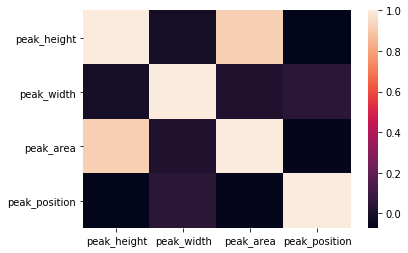

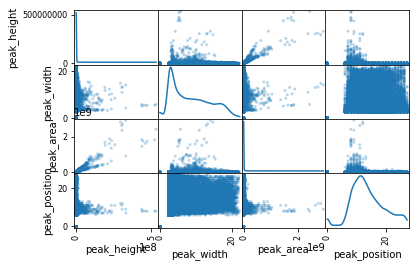

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

peak_props_all_data = merged_data_set[peak_properties]

sns.heatmap(peak_props_all_data.corr())

# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(peak_props_all_data, alpha=0.3, diagonal='kde')

plt.show()

You can tell there is a strong correlation between peak height and area. This makes sense that area under our peak would be calculated based on height. Let’s remove area and see if we can see any other correlations once we break down the data to important compound to mass pair associations

Mass pair ID:  0
Compound id:  10


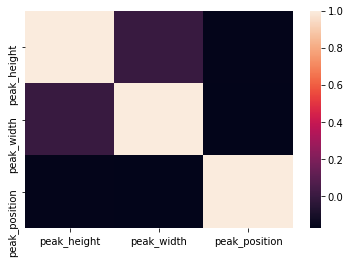

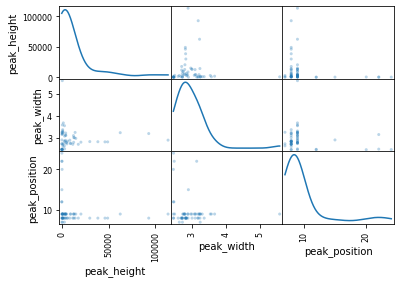

Mass pair ID:  2
Compound id:  4


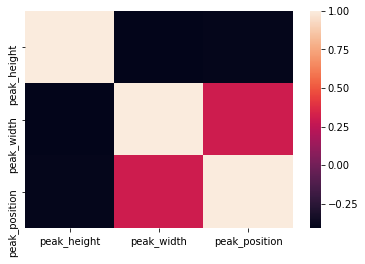

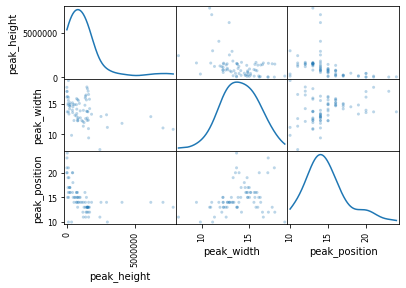

Mass pair ID:  3
Compound id:  10


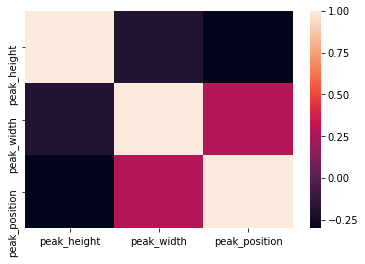

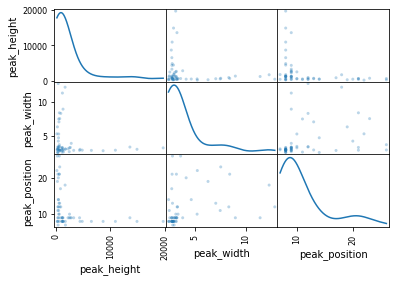

Mass pair ID:  4
Compound id:  10


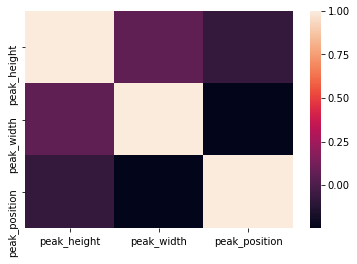

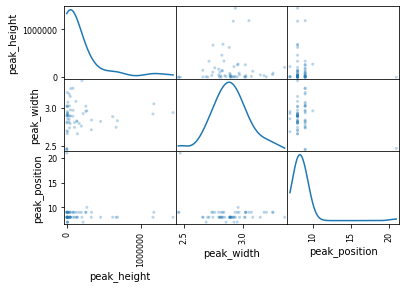

Mass pair ID:  7
Compound id:  19


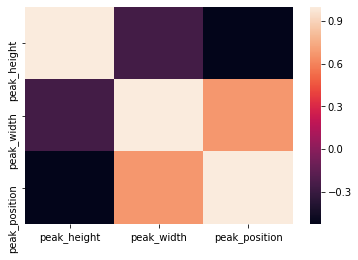

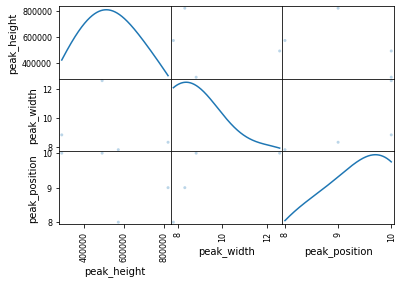

Mass pair ID:  8
Compound id:  19


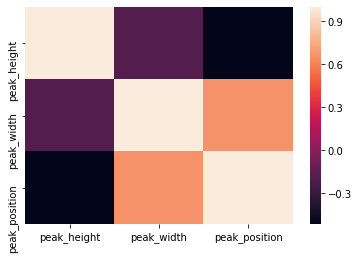

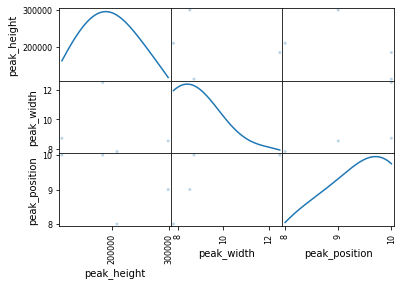

Mass pair ID:  11
Compound id:  4


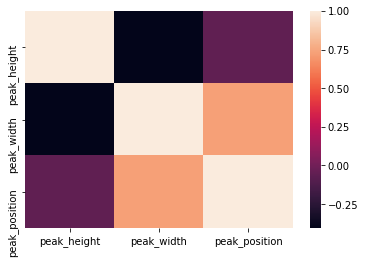

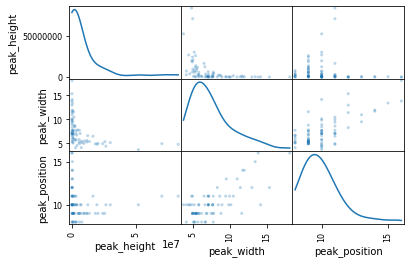

Mass pair ID:  16
Compound id:  14


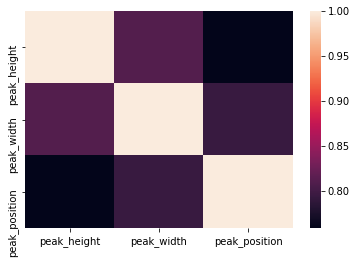

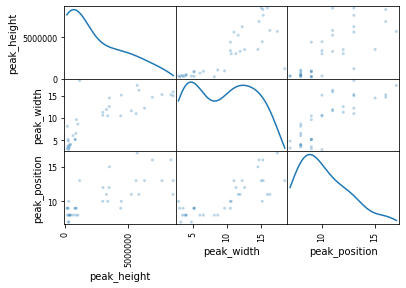

Mass pair ID:  16
Compound id:  7


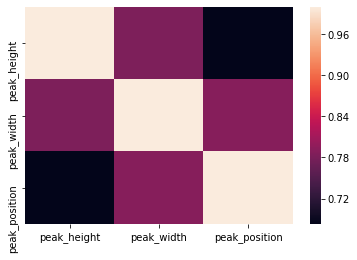

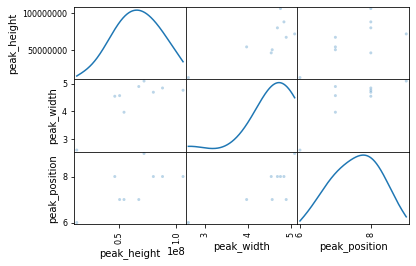

Mass pair ID:  16
Compound id:  8


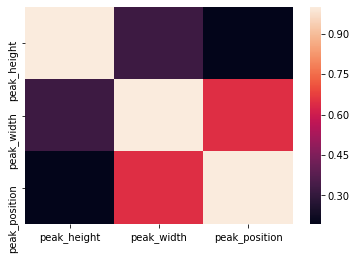

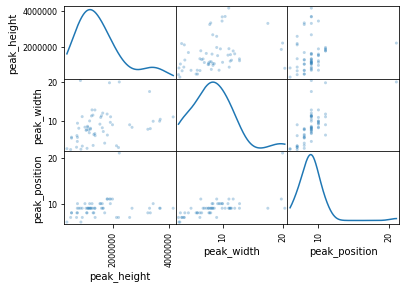

Mass pair ID:  18
Compound id:  14


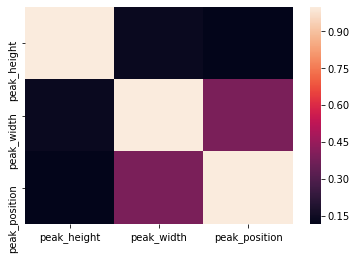

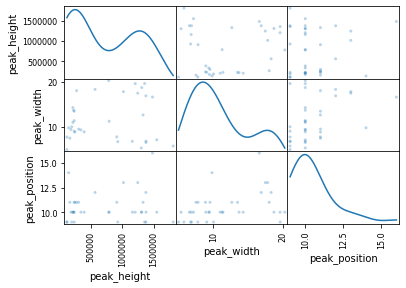

Mass pair ID:  18
Compound id:  7


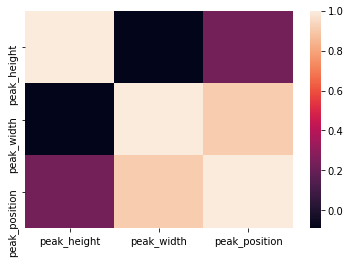

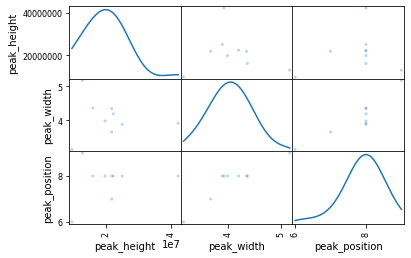

Mass pair ID:  18
Compound id:  8


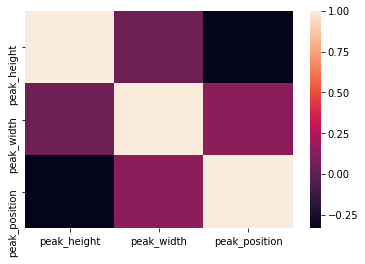

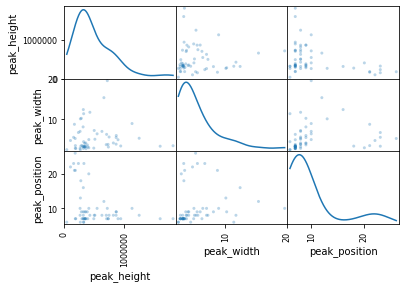

Mass pair ID:  19
Compound id:  10


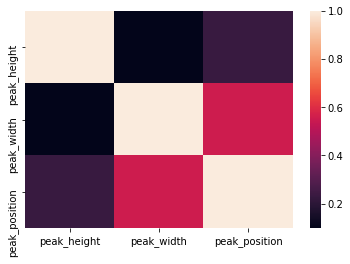

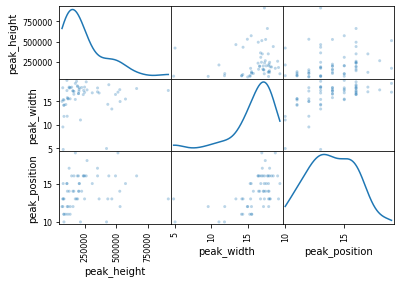

Mass pair ID:  19
Compound id:  18


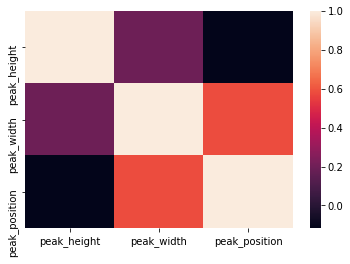

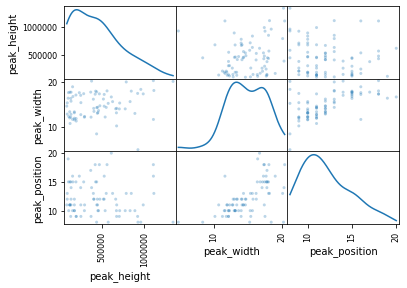

Mass pair ID:  20
Compound id:  10


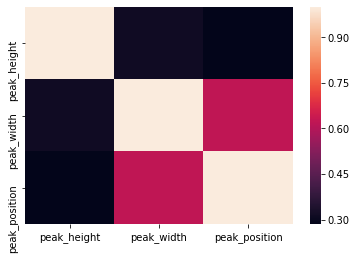

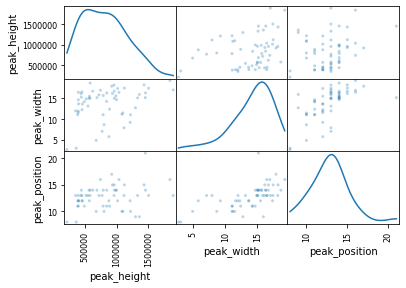

Mass pair ID:  20
Compound id:  18


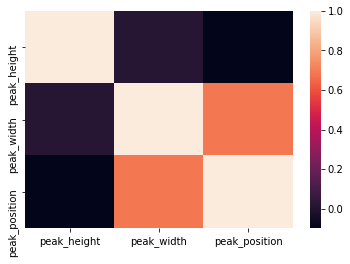

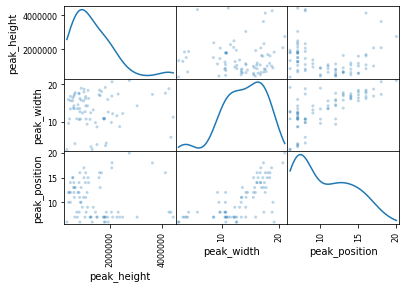

Mass pair ID:  20
Compound id:  3


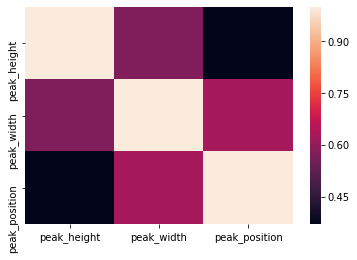

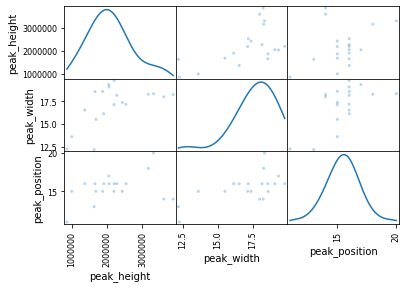

Mass pair ID:  21
Compound id:  18


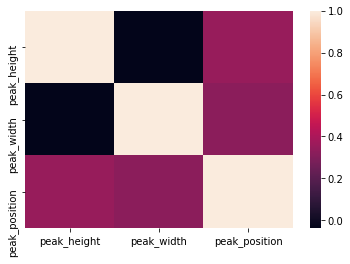

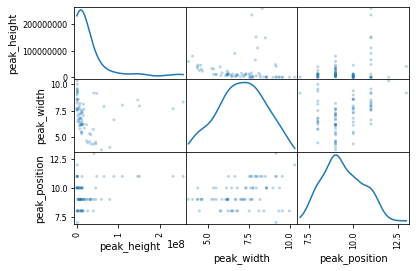

Mass pair ID:  22
Compound id:  10


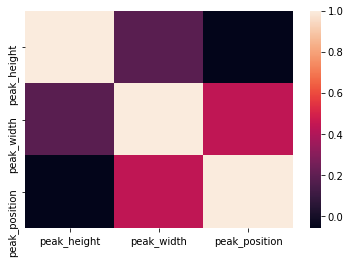

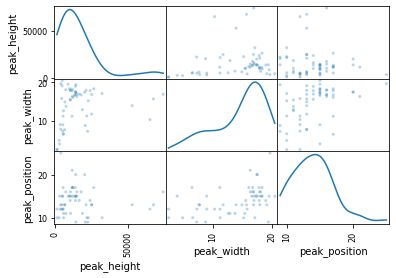

Mass pair ID:  22
Compound id:  21


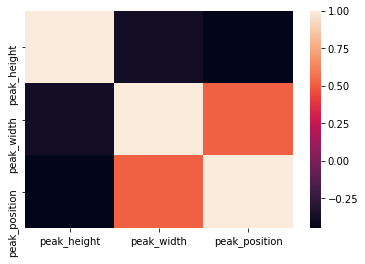

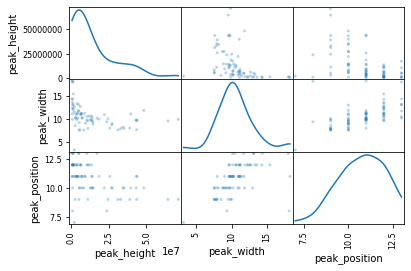

Mass pair ID:  22
Compound id:  0


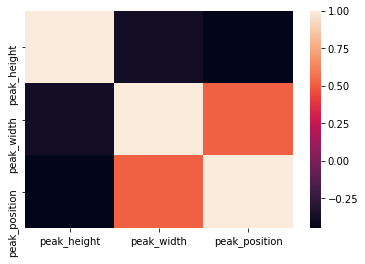

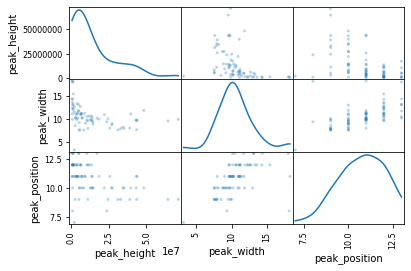

Mass pair ID:  23
Compound id:  10


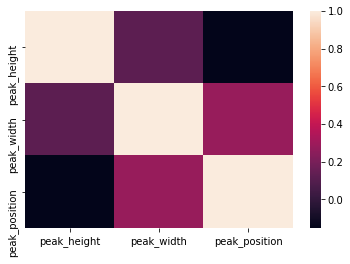

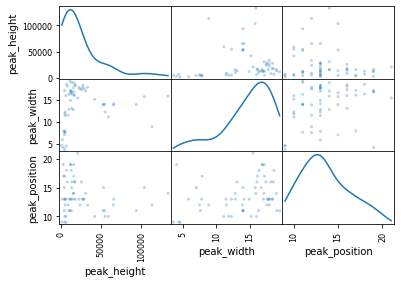

Mass pair ID:  23
Compound id:  21


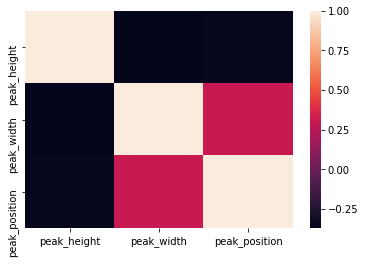

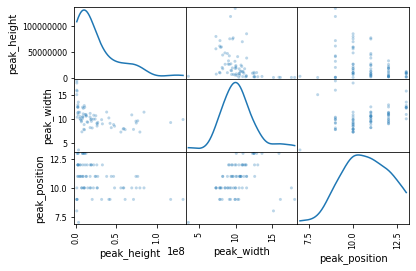

Mass pair ID:  23
Compound id:  0


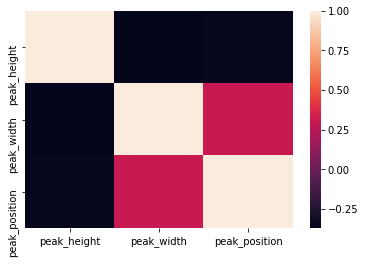

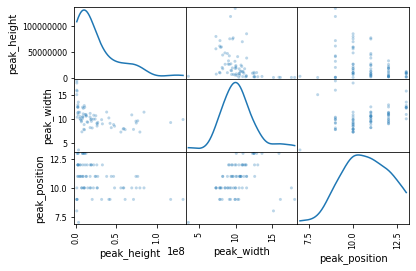

Mass pair ID:  25
Compound id:  21


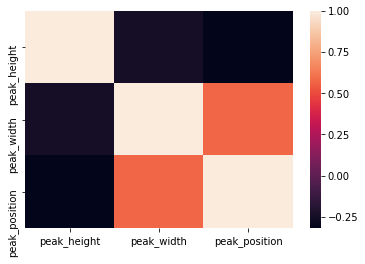

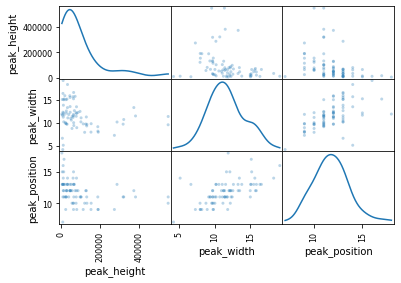

Mass pair ID:  25
Compound id:  0


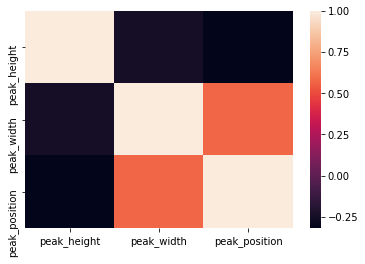

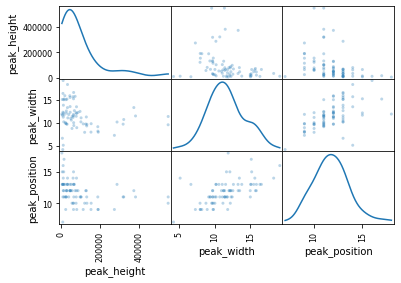

Mass pair ID:  26
Compound id:  21


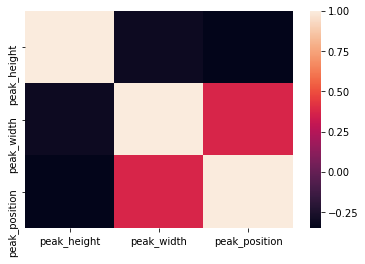

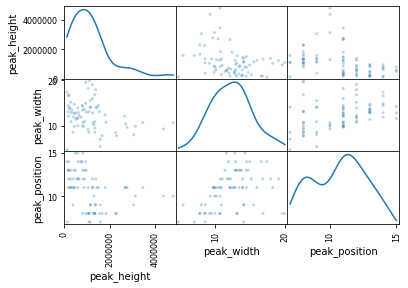

Mass pair ID:  26
Compound id:  0


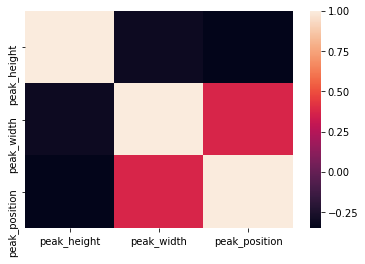

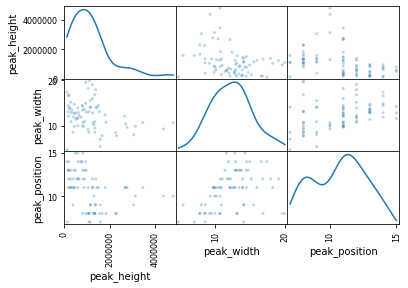

Mass pair ID:  27
Compound id:  7


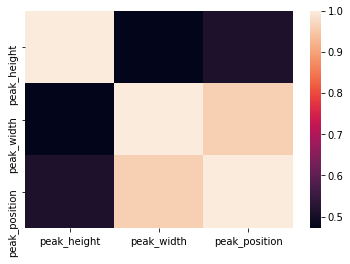

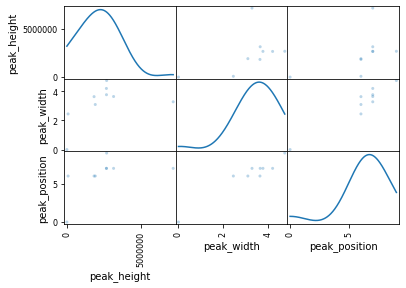

Mass pair ID:  30
Compound id:  7


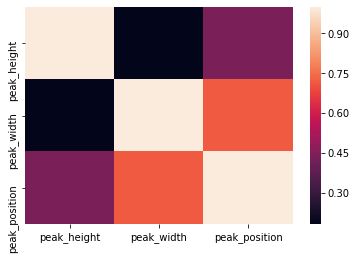

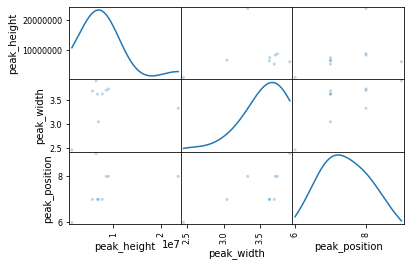

Mass pair ID:  33
Compound id:  21


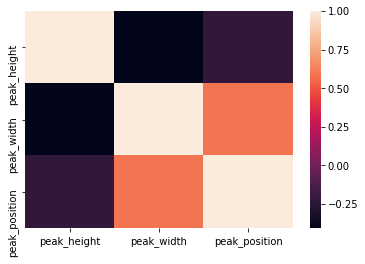

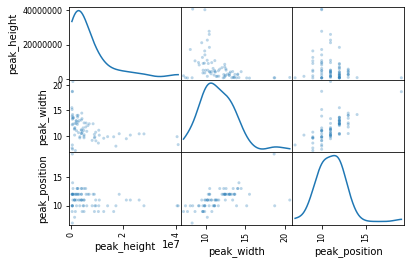

Mass pair ID:  33
Compound id:  0


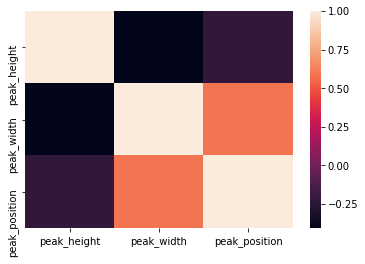

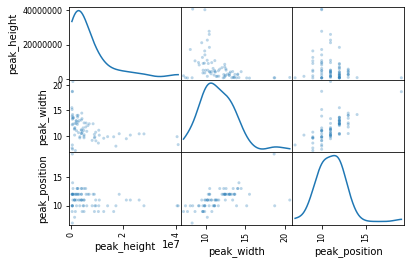

Mass pair ID:  34
Compound id:  21


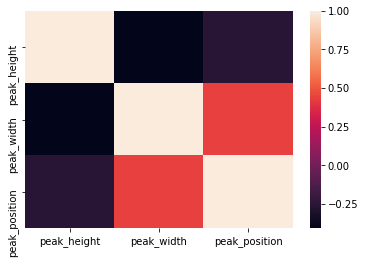

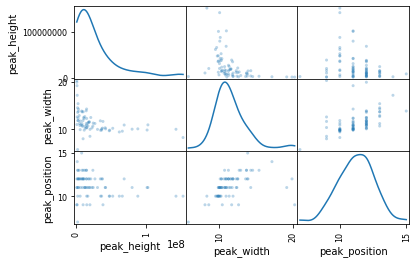

Mass pair ID:  34
Compound id:  0


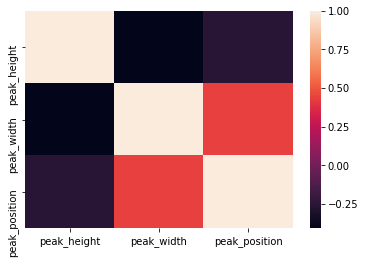

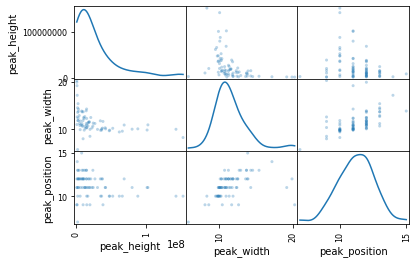

Mass pair ID:  35
Compound id:  22


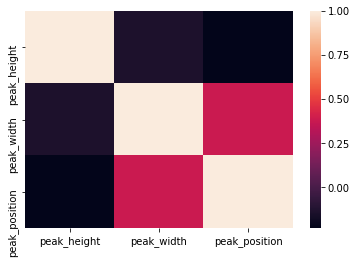

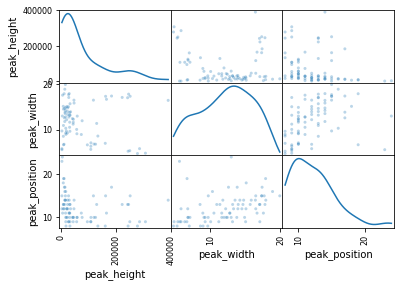

Mass pair ID:  36
Compound id:  15


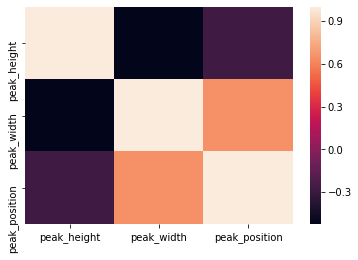

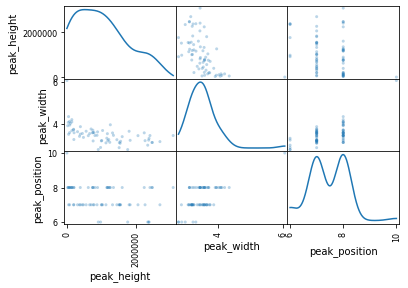

Mass pair ID:  37
Compound id:  22


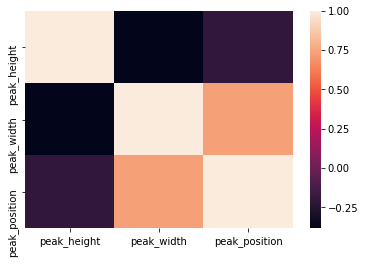

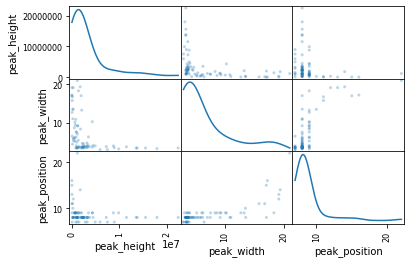

Mass pair ID:  38
Compound id:  22


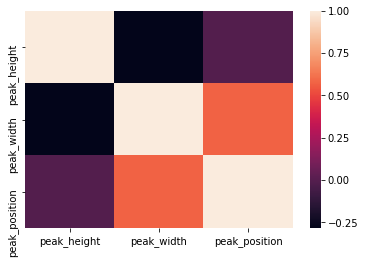

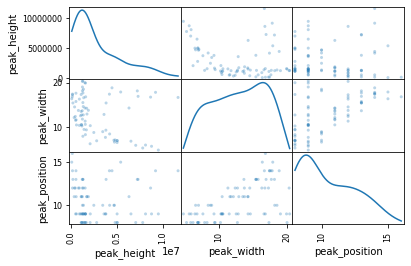

Mass pair ID:  39
Compound id:  15


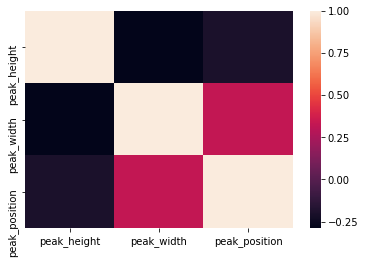

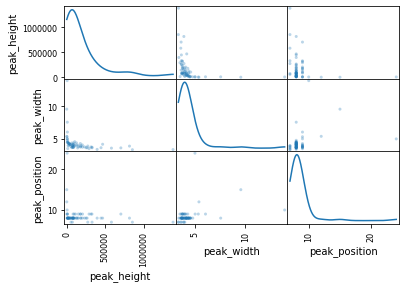

Mass pair ID:  39
Compound id:  8


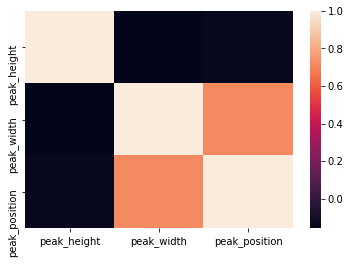

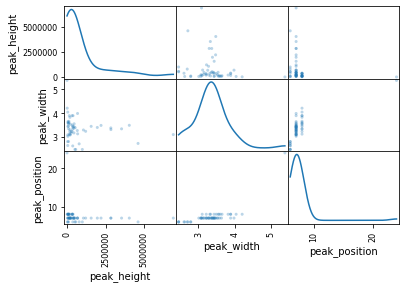

Mass pair ID:  40
Compound id:  18


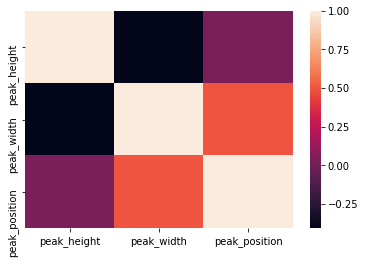

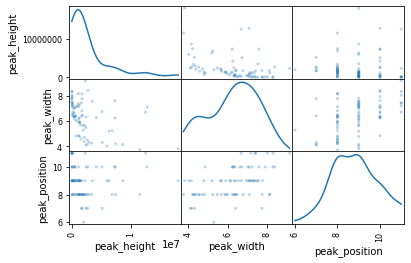

Mass pair ID:  41
Compound id:  13


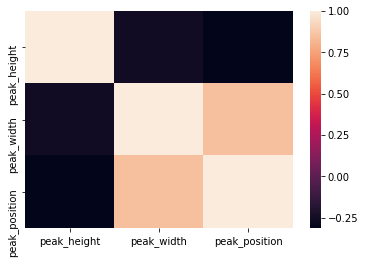

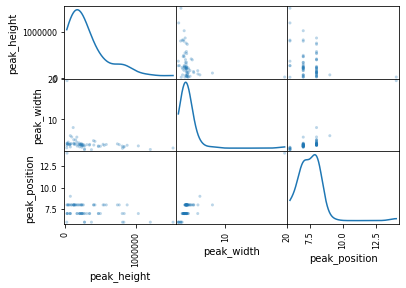

Mass pair ID:  42
Compound id:  13


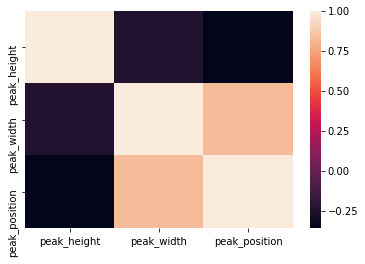

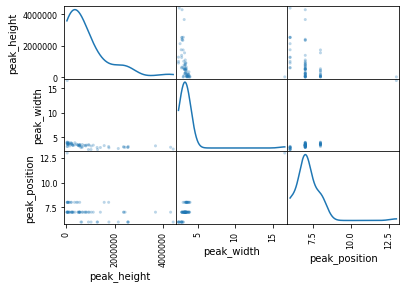

Mass pair ID:  46
Compound id:  13


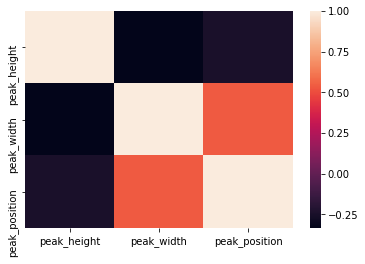

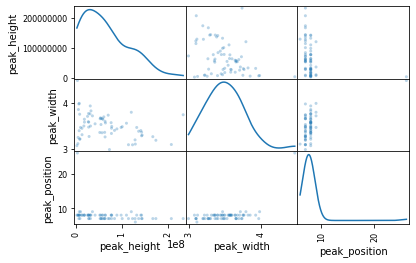

Mass pair ID:  46
Compound id:  14


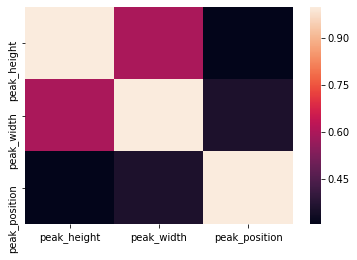

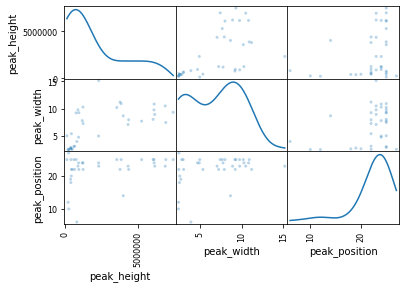

Mass pair ID:  46
Compound id:  15


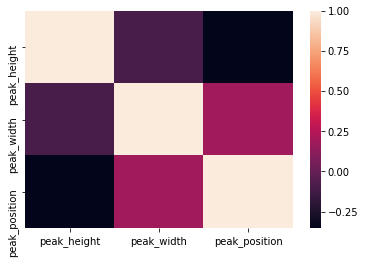

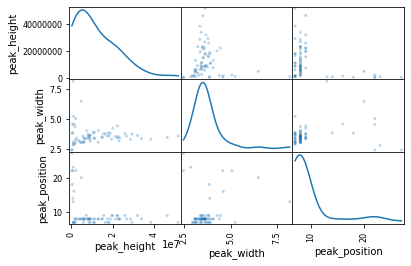

Mass pair ID:  46
Compound id:  7


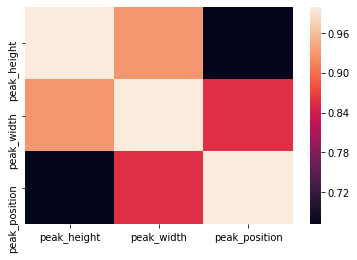

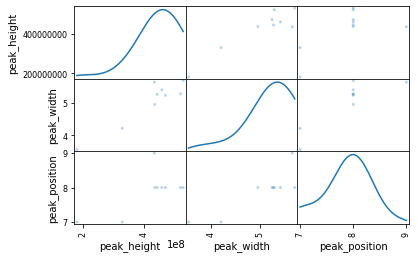

Mass pair ID:  46
Compound id:  8


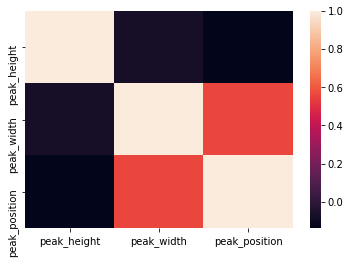

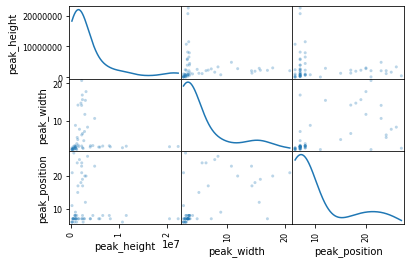

Mass pair ID:  47
Compound id:  3


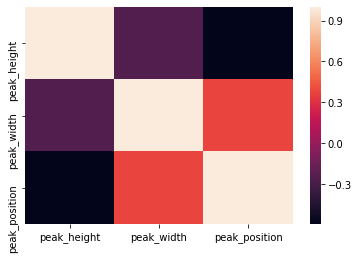

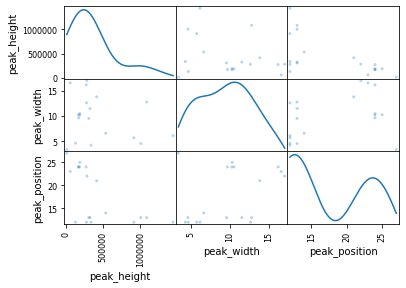

Mass pair ID:  49
Compound id:  3


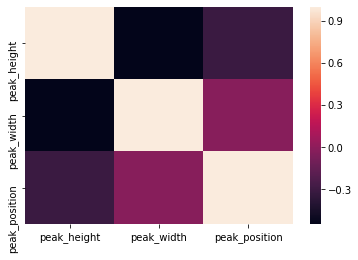

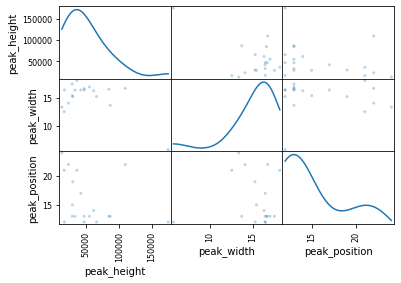

Mass pair ID:  50
Compound id:  3


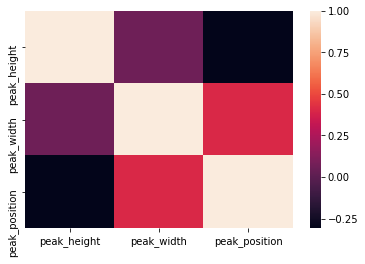

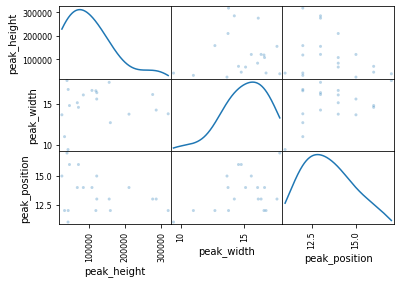

In [8]:
peak_properties = ['peak_height', 'peak_width', 'peak_position']

for mass_pair_id, compound_id_to_dataset in mass_pair_id_to_compound_ids_to_dataset.items():
    for compound_id, dataset in compound_id_to_dataset.items():
        if compound_id == -1:
            continue
        print("Mass pair ID: ", mass_pair_id)  
        print("Compound id: ", compound_id)
        peak_props = dataset[peak_properties]
        sns.heatmap(peak_props.corr())

        # Produce a scatter matrix for each pair of features in the data
        pd.plotting.scatter_matrix(peak_props, alpha=0.3, diagonal='kde')
        
        plt.show()

In most cases there is no other correlation. Some of the heatmaps show a little bit, but I think it could just be due to a lack of samples. Most of the scatter plots show a shifted gaussian curve. I am going to apply a log transform to see if I can center the gaussian  curves.

Mass pair ID:  0
Compound id:  10


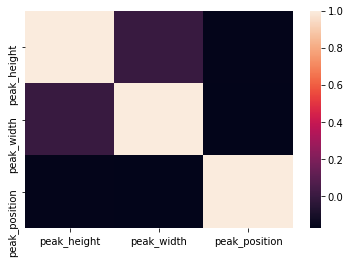

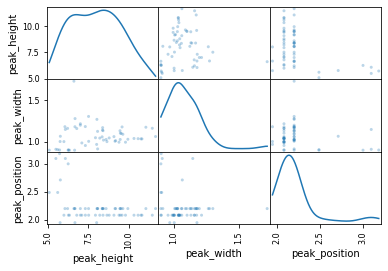

Mass pair ID:  2
Compound id:  4


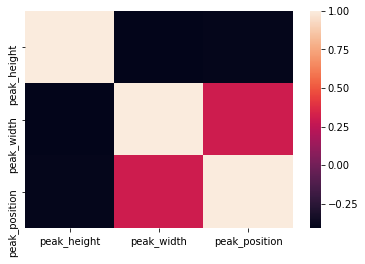

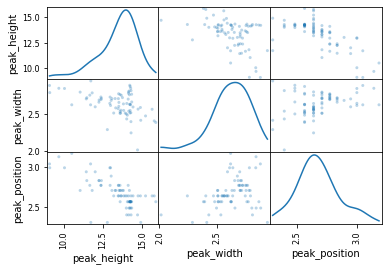

Mass pair ID:  3
Compound id:  10


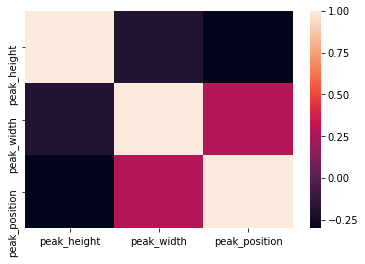

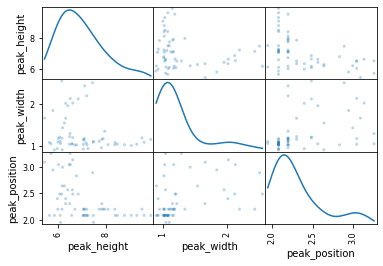

Mass pair ID:  4
Compound id:  10


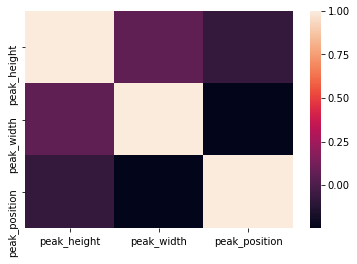

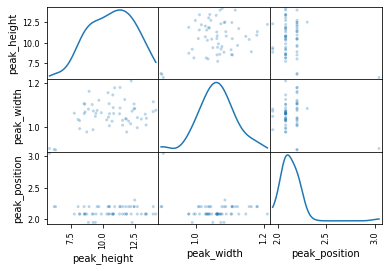

Mass pair ID:  7
Compound id:  19


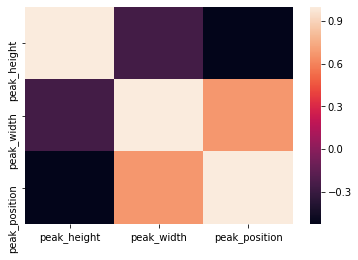

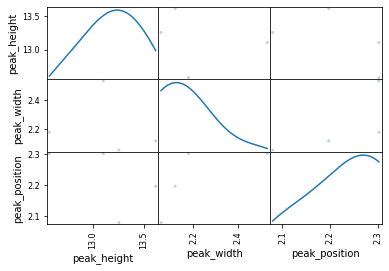

Mass pair ID:  8
Compound id:  19


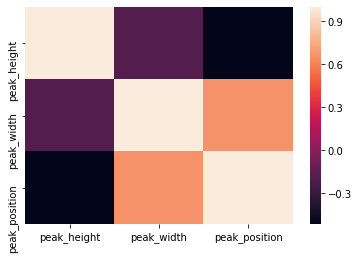

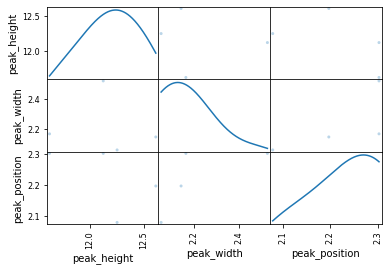

Mass pair ID:  11
Compound id:  4


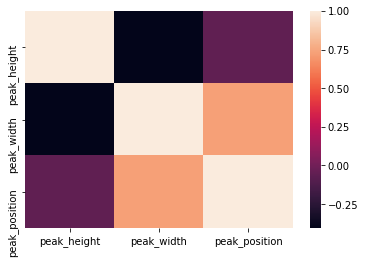

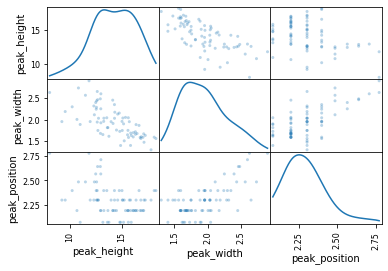

Mass pair ID:  16
Compound id:  14


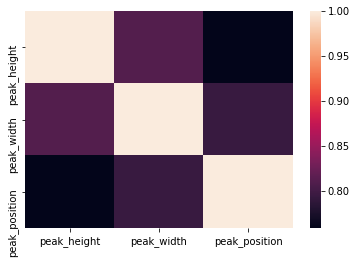

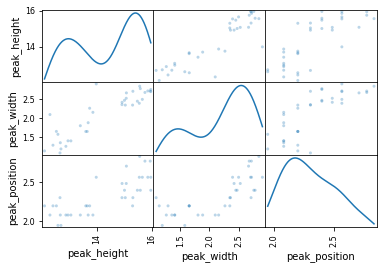

Mass pair ID:  16
Compound id:  7


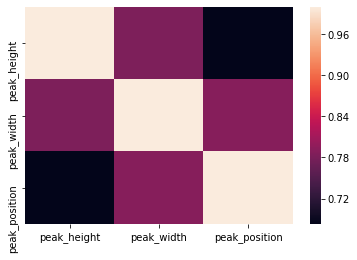

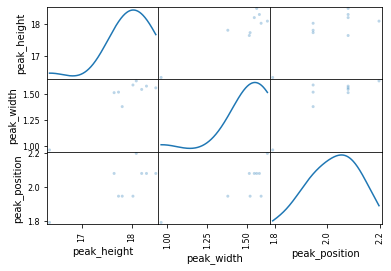

Mass pair ID:  16
Compound id:  8


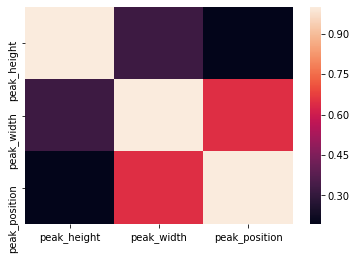

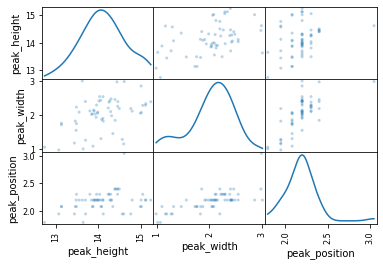

Mass pair ID:  18
Compound id:  14


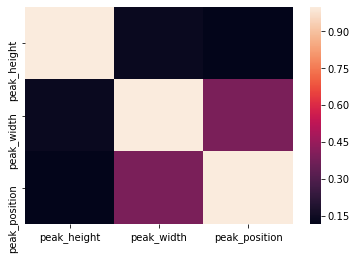

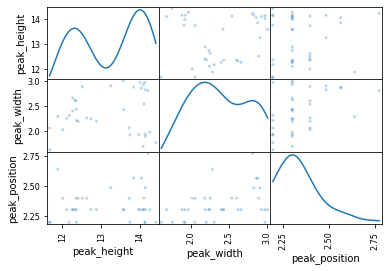

Mass pair ID:  18
Compound id:  7


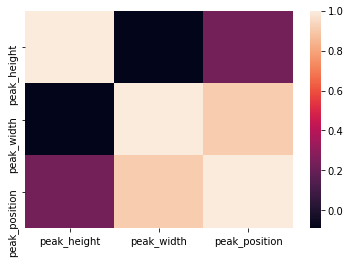

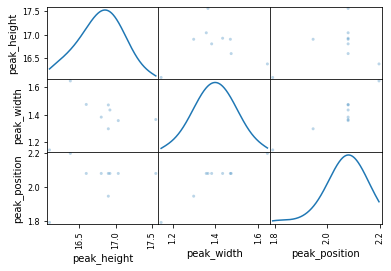

Mass pair ID:  18
Compound id:  8


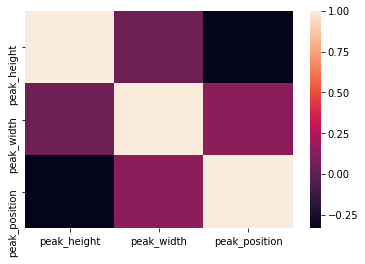

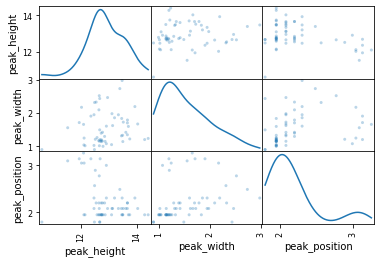

Mass pair ID:  19
Compound id:  10


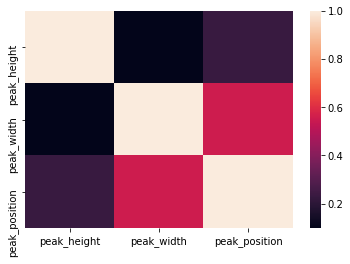

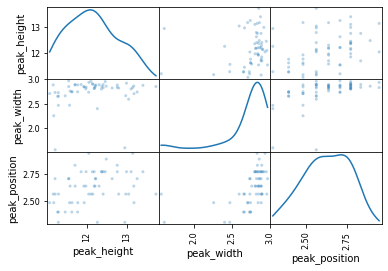

Mass pair ID:  19
Compound id:  18


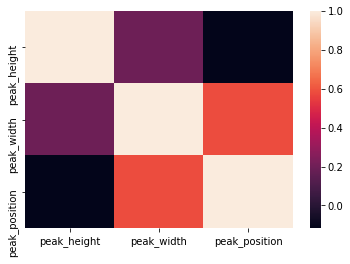

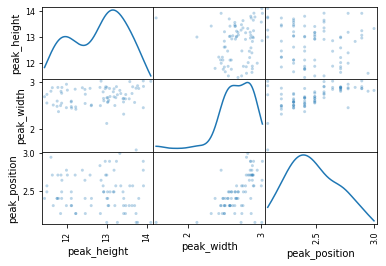

Mass pair ID:  20
Compound id:  10


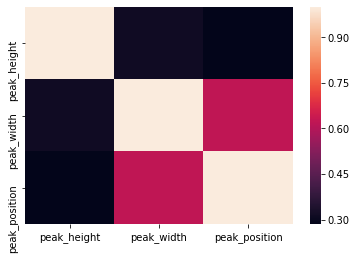

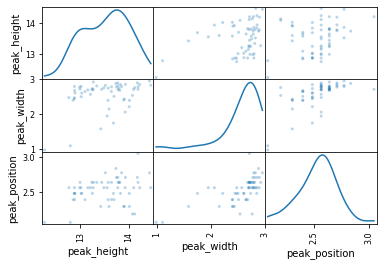

Mass pair ID:  20
Compound id:  18


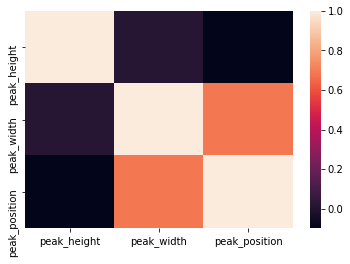

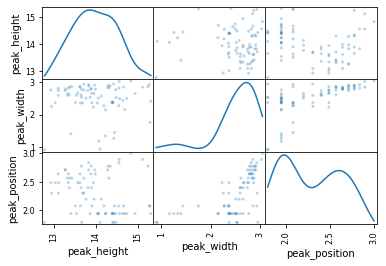

Mass pair ID:  20
Compound id:  3


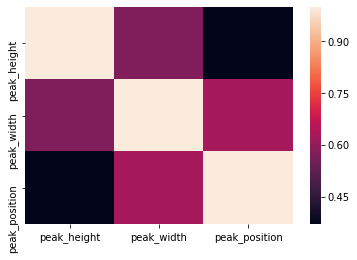

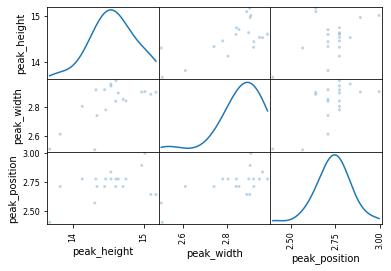

Mass pair ID:  21
Compound id:  18


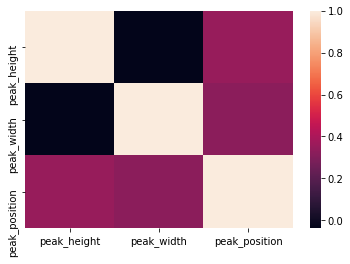

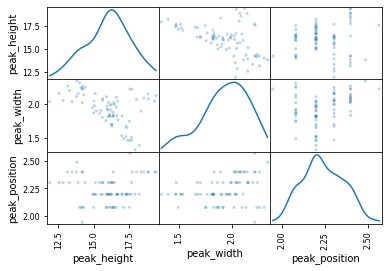

Mass pair ID:  22
Compound id:  10


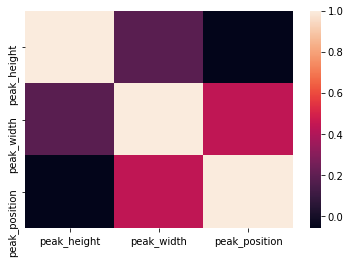

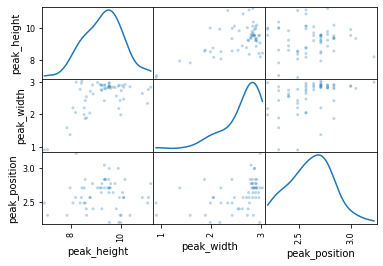

Mass pair ID:  22
Compound id:  21


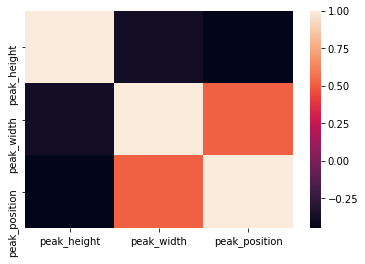

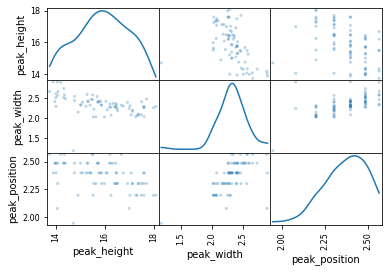

Mass pair ID:  22
Compound id:  0


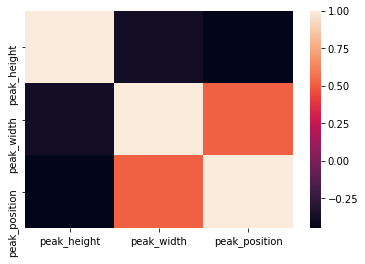

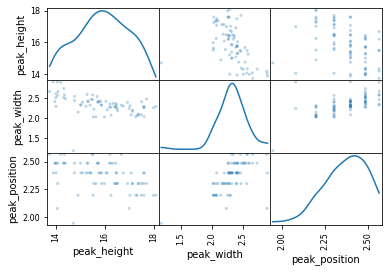

Mass pair ID:  23
Compound id:  10


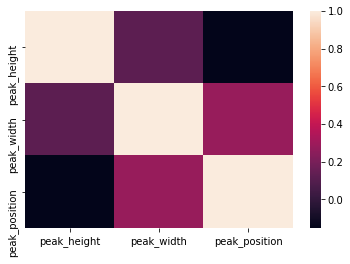

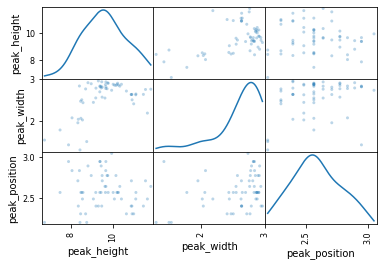

Mass pair ID:  23
Compound id:  21


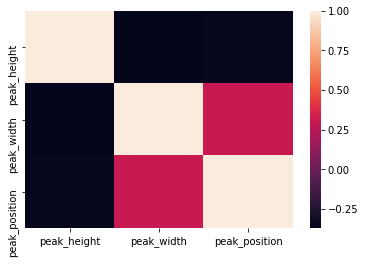

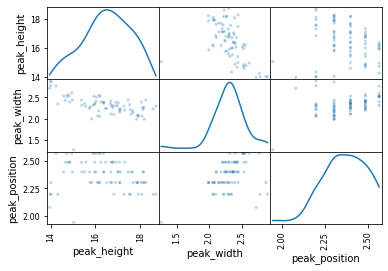

Mass pair ID:  23
Compound id:  0


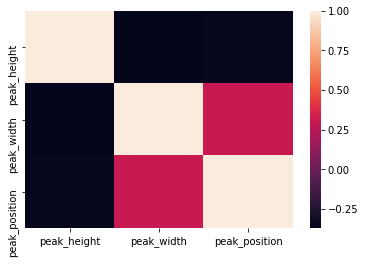

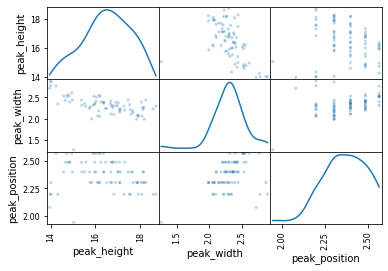

Mass pair ID:  25
Compound id:  21


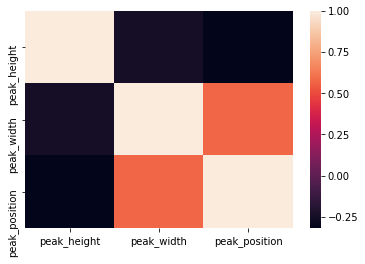

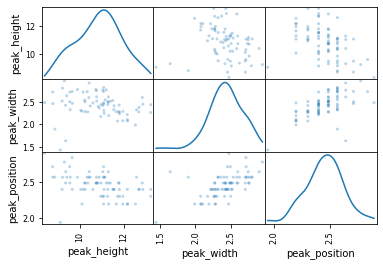

Mass pair ID:  25
Compound id:  0


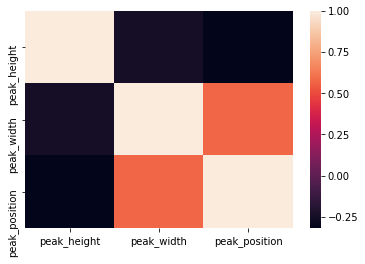

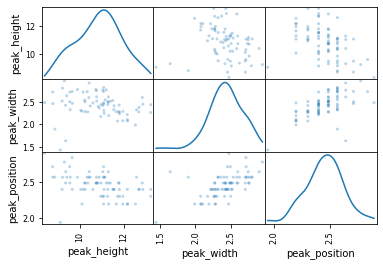

Mass pair ID:  26
Compound id:  21


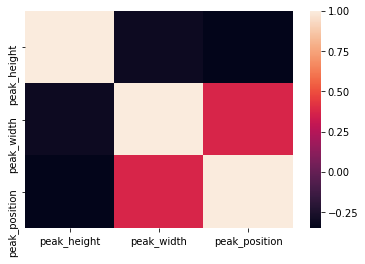

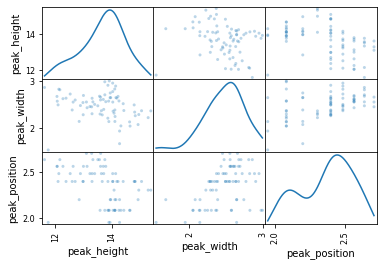

Mass pair ID:  26
Compound id:  0


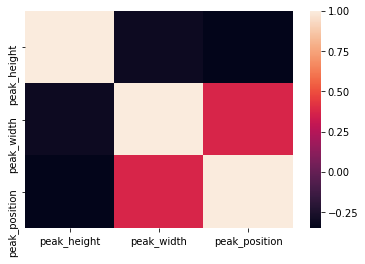

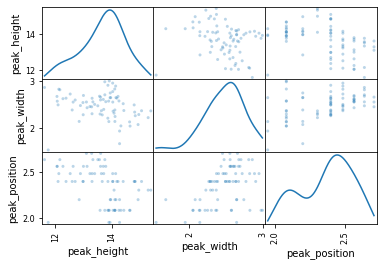

Mass pair ID:  27
Compound id:  7


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


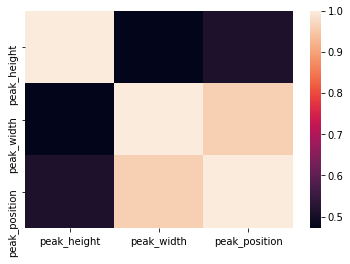

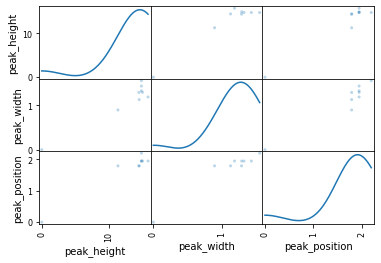

Mass pair ID:  30
Compound id:  7


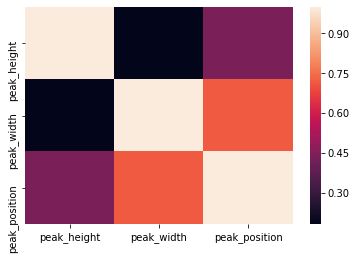

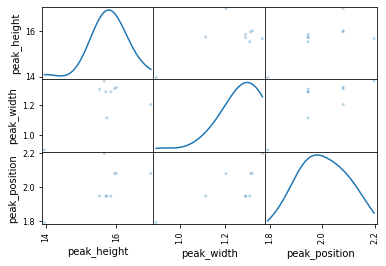

Mass pair ID:  33
Compound id:  21


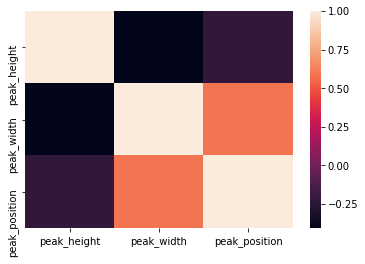

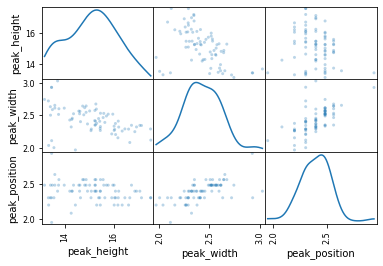

Mass pair ID:  33
Compound id:  0


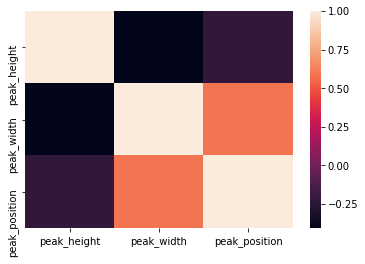

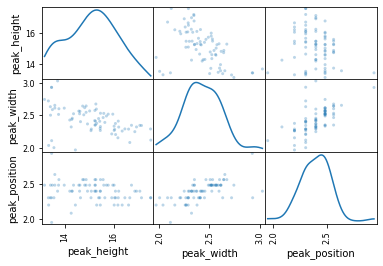

Mass pair ID:  34
Compound id:  21


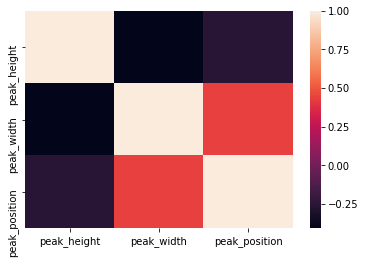

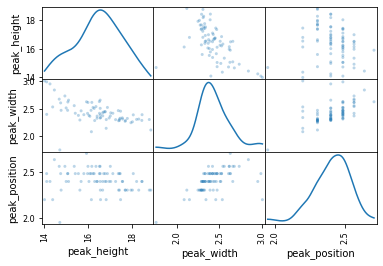

Mass pair ID:  34
Compound id:  0


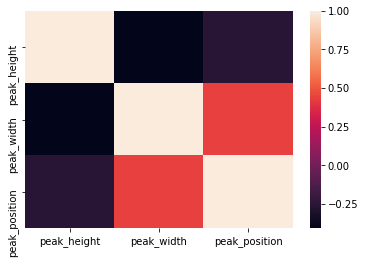

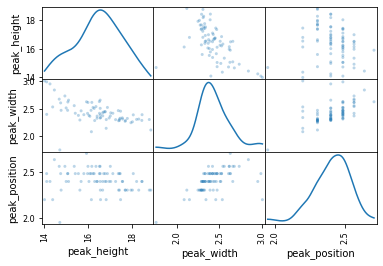

Mass pair ID:  35
Compound id:  22


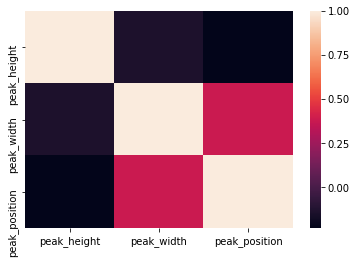

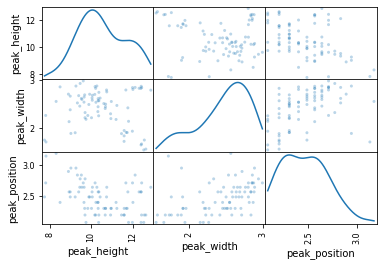

Mass pair ID:  36
Compound id:  15


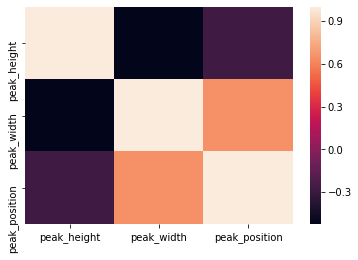

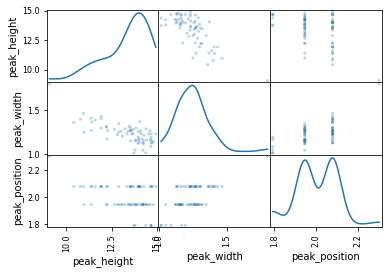

Mass pair ID:  37
Compound id:  22


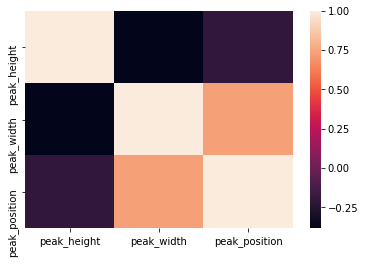

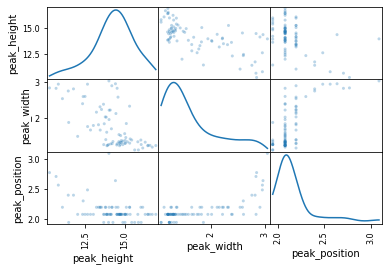

Mass pair ID:  38
Compound id:  22


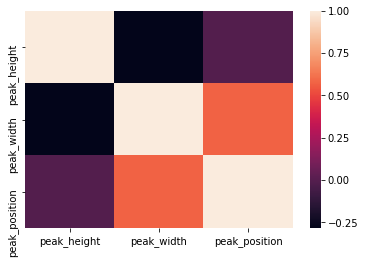

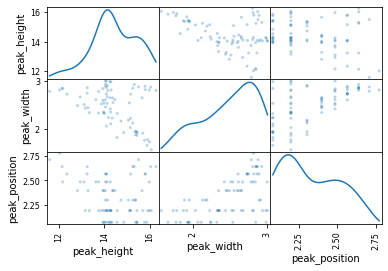

Mass pair ID:  39
Compound id:  15


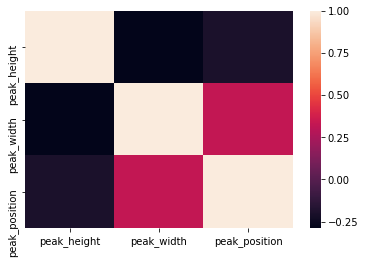

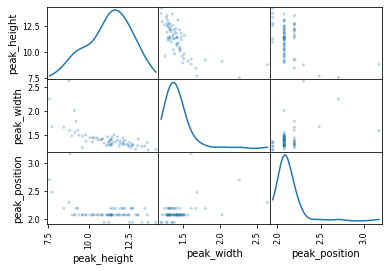

Mass pair ID:  39
Compound id:  8


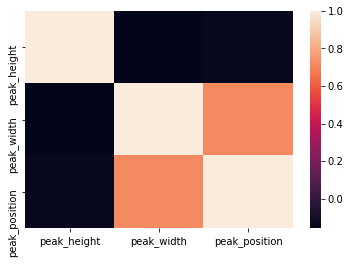

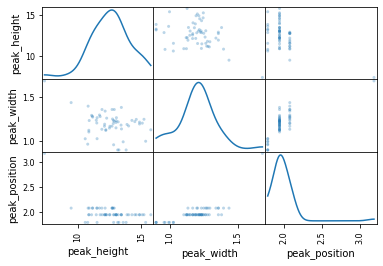

Mass pair ID:  40
Compound id:  18


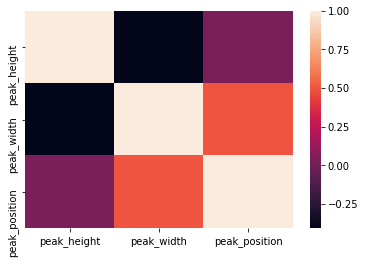

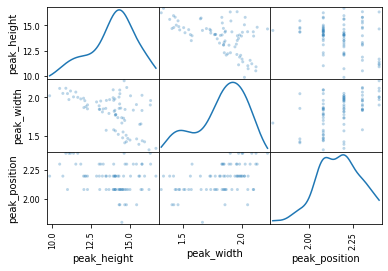

Mass pair ID:  41
Compound id:  13


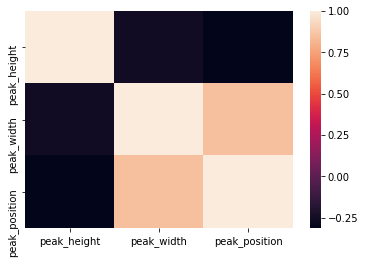

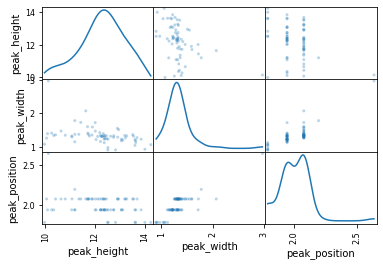

Mass pair ID:  42
Compound id:  13


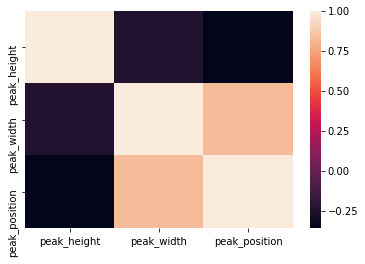

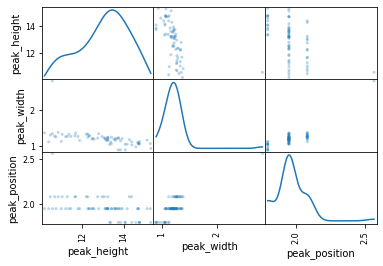

Mass pair ID:  46
Compound id:  13


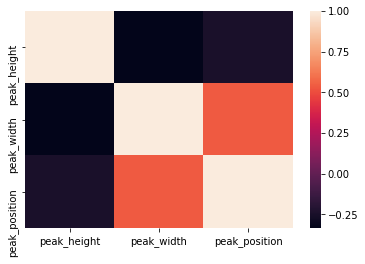

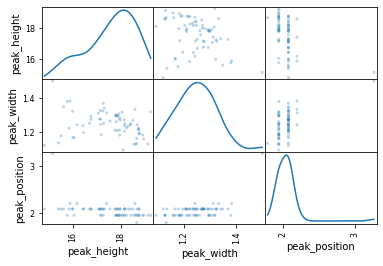

Mass pair ID:  46
Compound id:  14


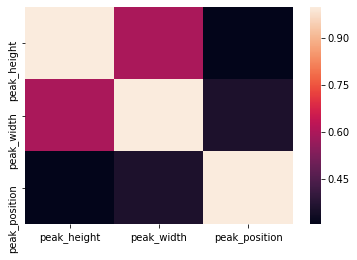

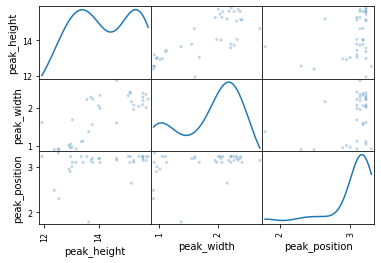

Mass pair ID:  46
Compound id:  15


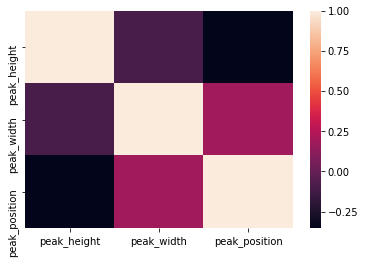

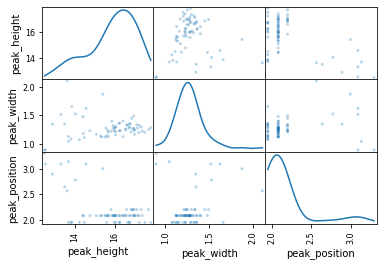

Mass pair ID:  46
Compound id:  7


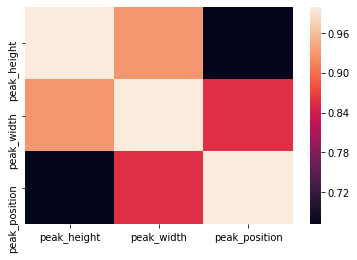

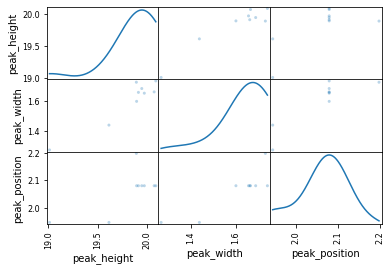

Mass pair ID:  46
Compound id:  8


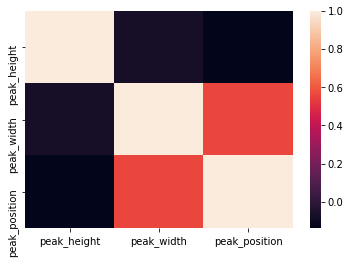

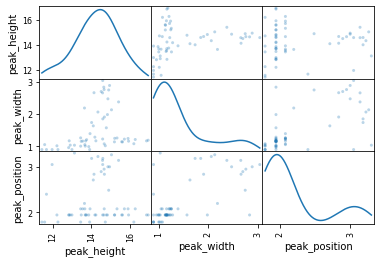

Mass pair ID:  47
Compound id:  3


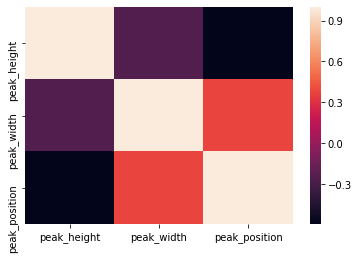

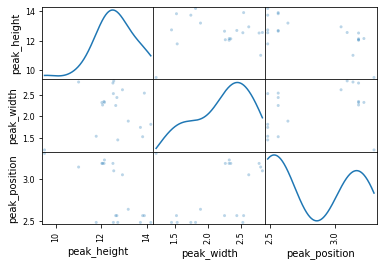

Mass pair ID:  49
Compound id:  3


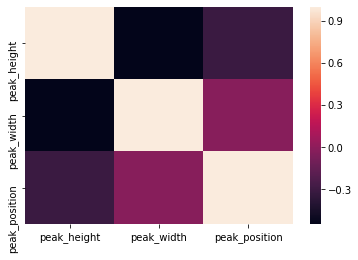

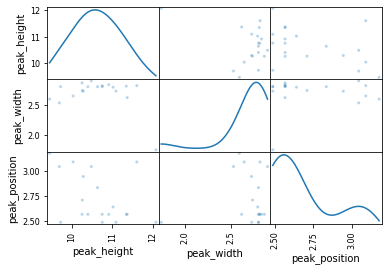

Mass pair ID:  50
Compound id:  3


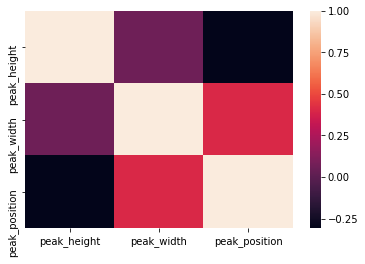

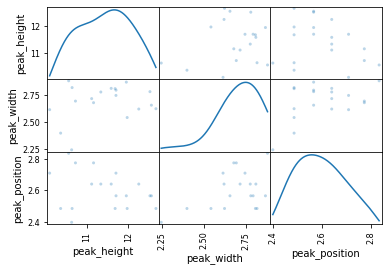

In [9]:
import numpy as np

for mass_pair_id, compound_id_to_dataset in mass_pair_id_to_compound_ids_to_dataset.items():
    for compound_id, dataset in compound_id_to_dataset.items():
        if compound_id == -1:
            continue
        print("Mass pair ID: ", mass_pair_id)  
        print("Compound id: ", compound_id)
        peak_props = dataset[peak_properties]
        sns.heatmap(peak_props.corr())

        # Produce a scatter matrix for each pair of features in the data
        pd.plotting.scatter_matrix(np.log(peak_props).replace([np.inf, -np.inf], np.nan).fillna(0), alpha=0.3, diagonal='kde')
        
        plt.show()

For the most part, width seems to be a very stable and independent feature. Position and height even though not correlated tend to mimic each other so I could probably get away with using either just height or position. I will try position because it previously had the least amount of standard deviation. Some of the mass pair to compounds are much more stable than others. On all cases, there are some outliers. Depending on the algorithm I use, I may need to remove these outliers to not overfit my model. Next, I want to plot and label all my mass pair data to get an idea of how well my algorithm will do on test data.

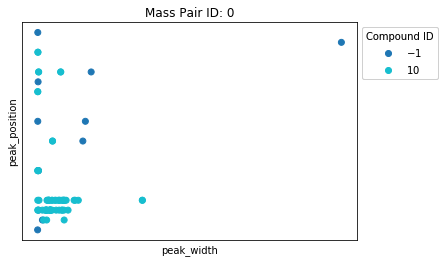

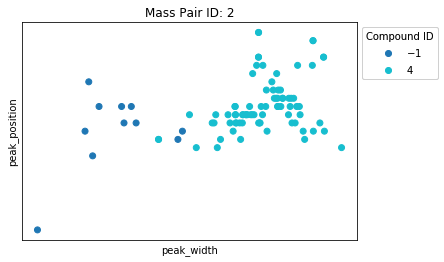

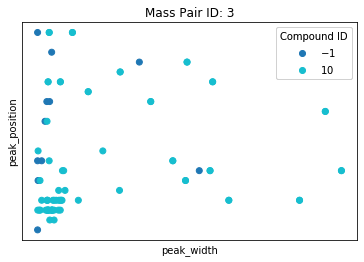

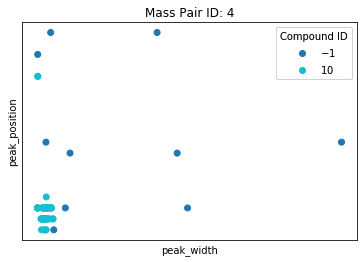

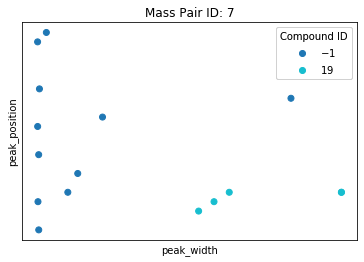

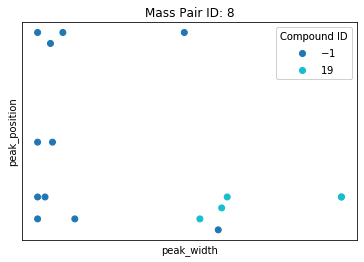

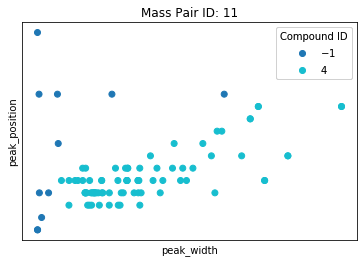

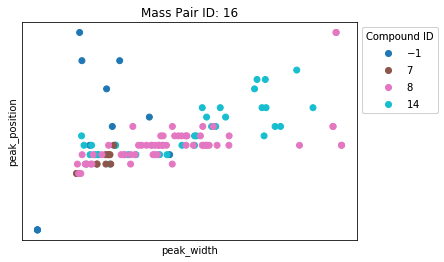

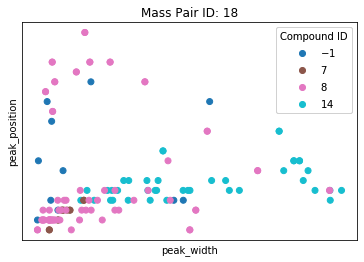

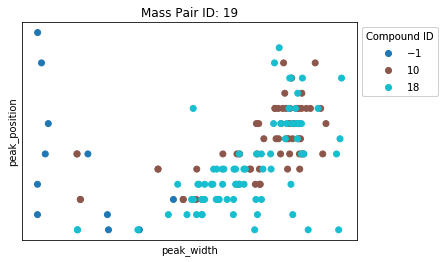

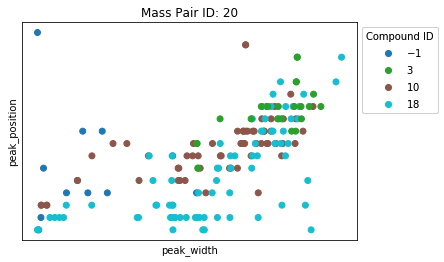

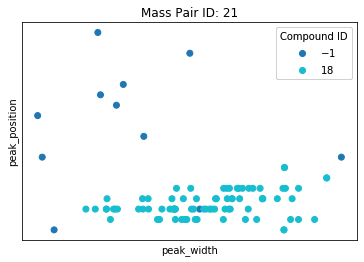

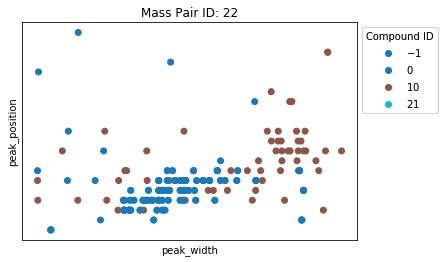

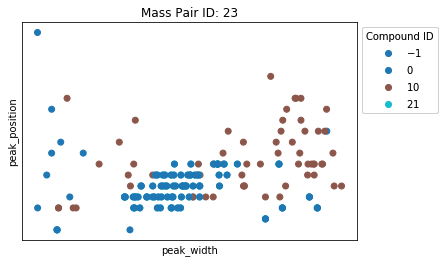

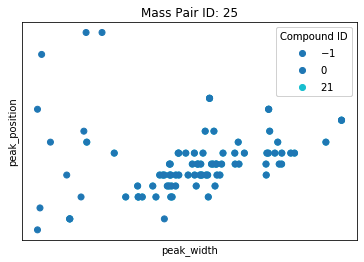

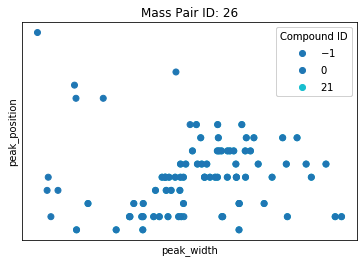

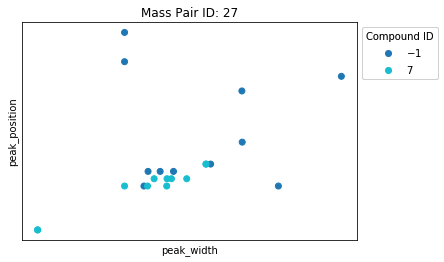

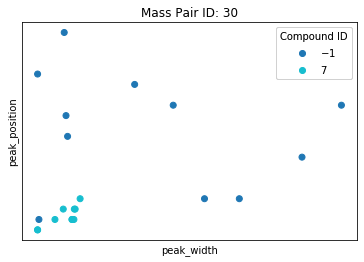

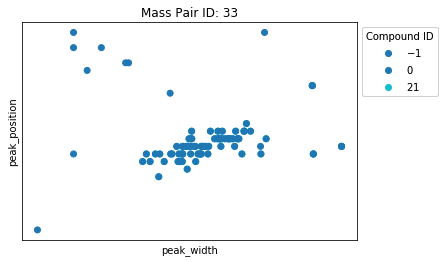

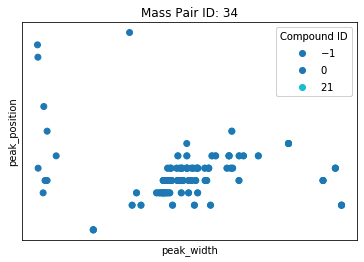

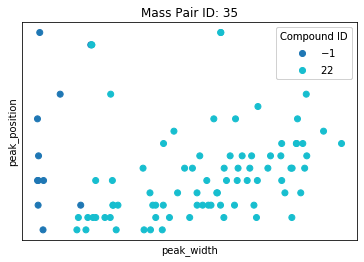

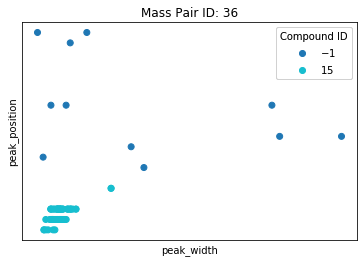

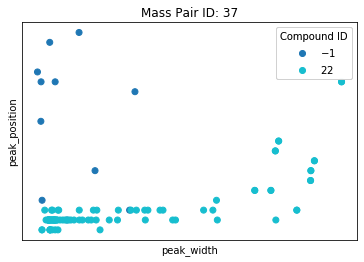

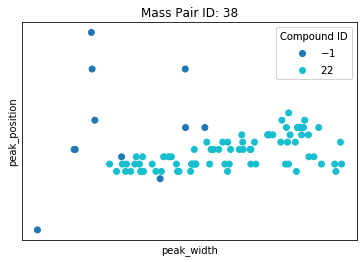

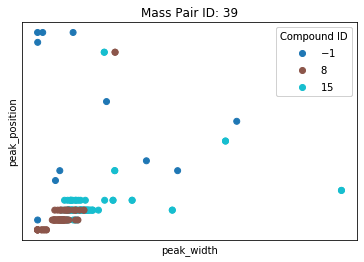

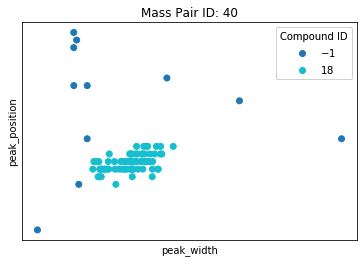

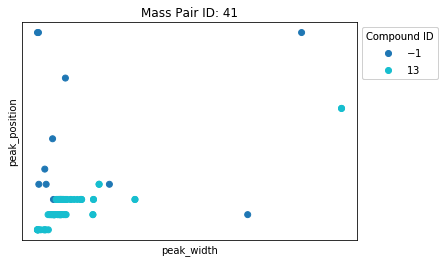

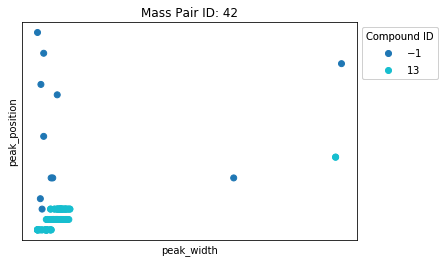

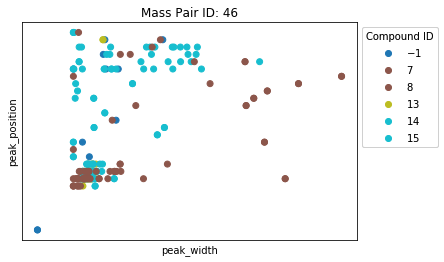

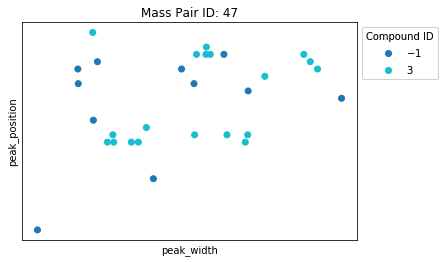

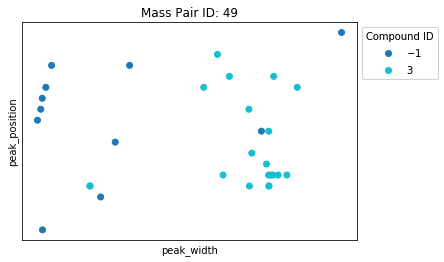

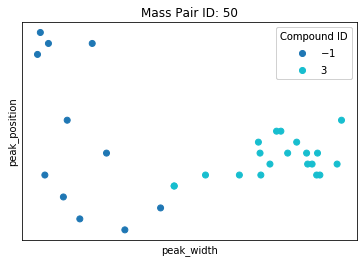

In [38]:
def find_outliers(gaussian_data: pd.DataFrame):
    outliers = []
    commonOutliers = []

    # For each feature find the data points with extreme high or low values
    for feature in gaussian_data.keys():
        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(gaussian_data[feature], 25)

        # Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(gaussian_data[feature], 75)

        # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = (Q3 - Q1) * 1.5

        data = gaussian_data[~((gaussian_data[feature] >= Q1 - step) &
                               (gaussian_data[feature] <= Q3 + step))]

        # Display the outliers
        #print("Data points considered outliers for the feature '{}':".format(feature))
        #print(data)

        for index, _ in data.iterrows():
            if index not in outliers:
                outliers.append(index)
            elif index not in commonOutliers:
                commonOutliers.append(index)

    #print('Outliers:')
    #print(sorted(outliers))

    # Remove the outliers, if any were specified
    # good_data = gaussian_data.drop(outliers).reset_index(drop=True)
    return outliers

def plot_with_labels(mass_pair_id, compound_id_to_dataset, peak_properties, create_model=None):
    
    data = []
    outliers = []
    groups = []
    
    xColumnLabel, yColumnLabel = peak_properties
    
    for compound_id, dataset in compound_id_to_dataset.items():
        dataset = dataset[peak_properties]
        if compound_id == -1:
            outliers.append(None)
            groups.append('Noise')
        else:
            found_outliers_indices = find_outliers(dataset)
            outliers.append(dataset.loc[found_outliers_indices])
            #dataset = dataset.drop(found_outliers_indices).reset_index(drop=True)
            groups.append('Compound {}'.format(compound_id))
        data.append(dataset)
        
    if len(groups) <= 1:
        return
    
    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    title = 'Mass Pair ID: {}'.format(mass_pair_id)
    ax.set_xlabel(xColumnLabel)
    ax.set_ylabel(yColumnLabel)

    dataset = None
    for datum, group, outlier in zip(data, groups, outliers):
        if dataset is None:
            dataset = datum.assign(output=-1)#Noise is first
        else:
            output = int(group.split()[-1])
            temp = datum
            temp = temp.append(outlier)
            temp = temp.assign(output=output)
            dataset = dataset.append(temp)
                
    X = dataset[peak_properties].values
    y = dataset['output'].values
    
    #fit model
    if create_model is not None:
        model = create_model()
        
        
        h = .02  # step size in the mesh
        # create a mesh to plot in
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
        
        
        model.fit(X, y)
       
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.tab10, alpha=0.8)
        
    # Plot also the training points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab10)
    plt.xticks(())
    plt.yticks(())
    
    # produce a legend with the unique colors from the scatter
    legend = ax.legend(*scatter.legend_elements(), bbox_to_anchor=(1, 1), title="Compound ID")
    ax.add_artist(legend)
    
    #for datum, group, outlier in zip(data, groups, outliers):
    #    X1, X2 = datum[xColumnLabel], datum[yColumnLabel]
    #    ax.scatter(X1, X2, edgecolors='none', s=30, label=group, cmap=plt.cm.coolwarm)
    #    if outlier is not None and len(outlier) > 0:
    #        ax.scatter(outlier[xColumnLabel], outlier[yColumnLabel],
    #                   alpha=1, edgecolors='face', s=35, label='{} Outlier'.format(group))
    plt.title(title)

for mass_pair_id, compound_id_to_dataset in mass_pair_id_to_compound_ids_to_dataset.items():
    plot_with_labels(mass_pair_id, compound_id_to_dataset, ['peak_width', 'peak_position'])
    plt.show()
    

Some mass pairs look better than others. Let me see how height looks instead of position.

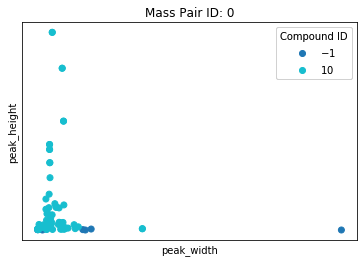

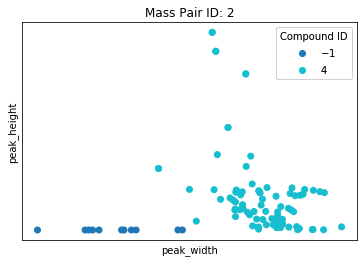

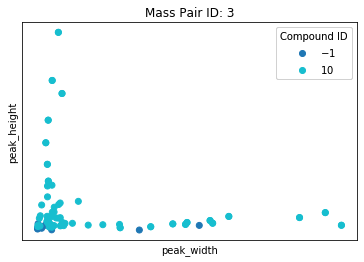

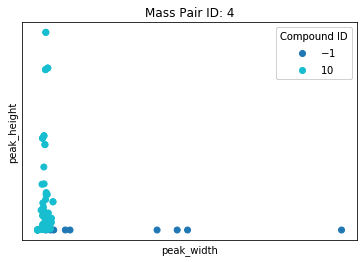

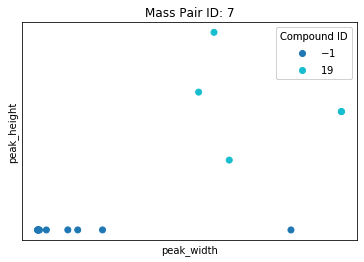

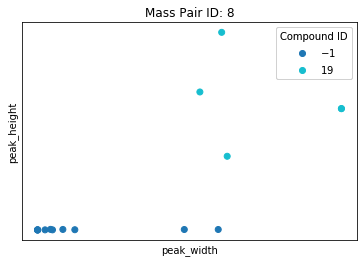

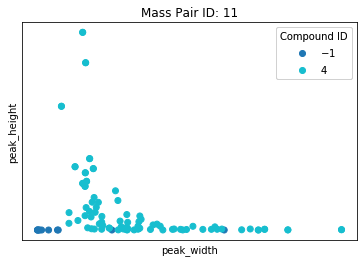

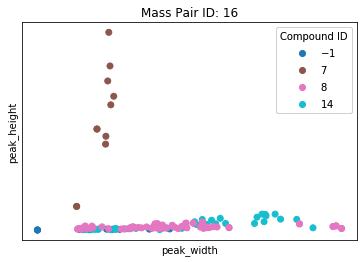

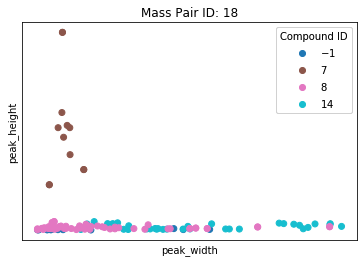

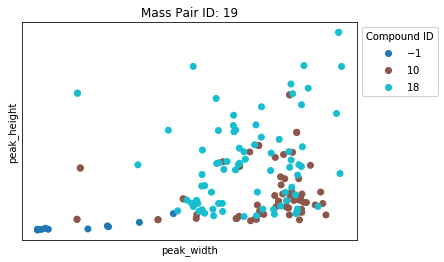

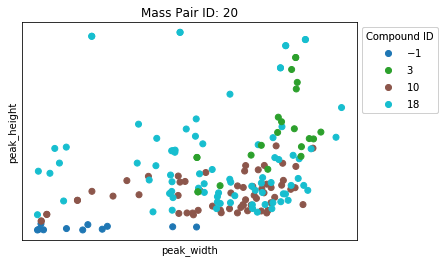

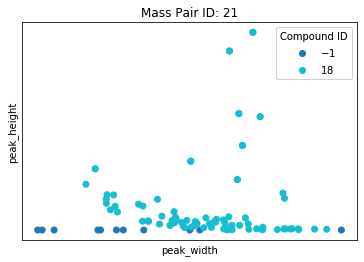

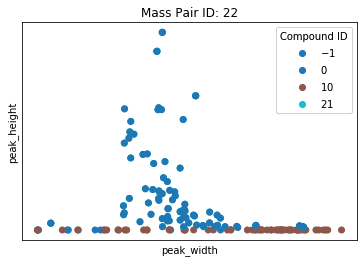

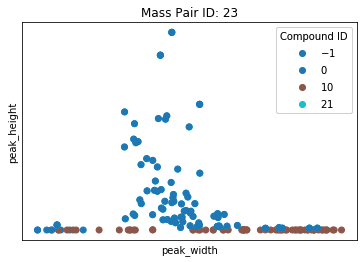

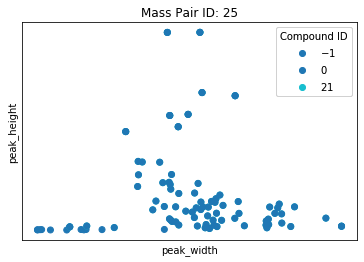

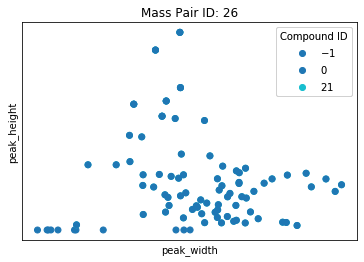

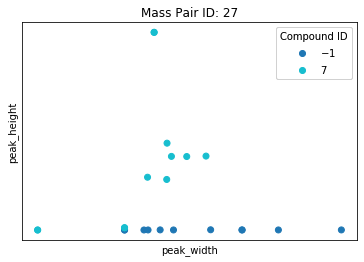

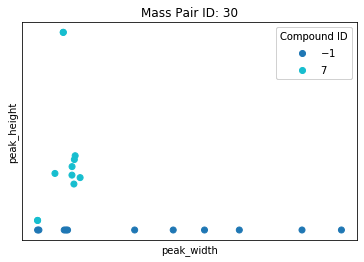

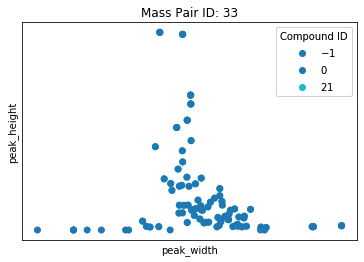

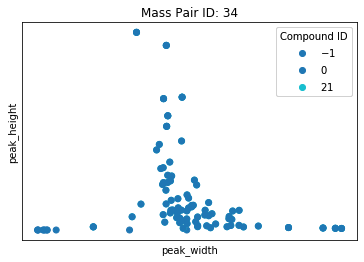

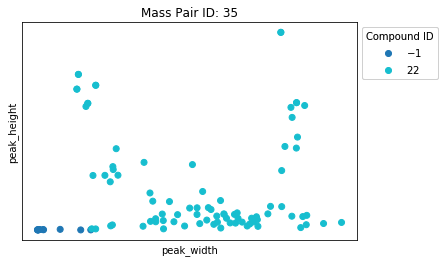

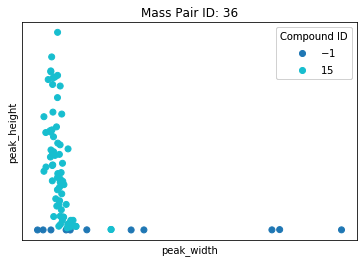

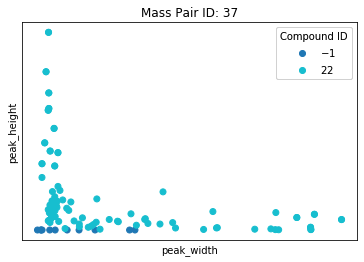

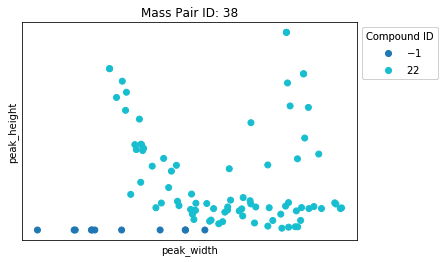

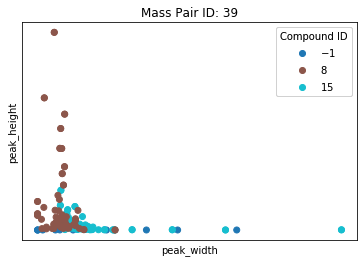

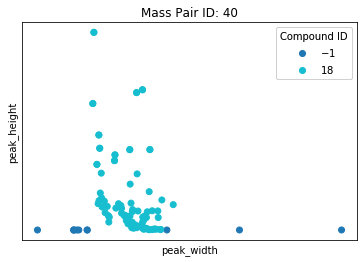

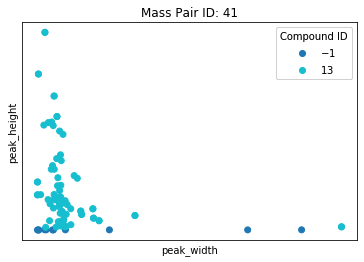

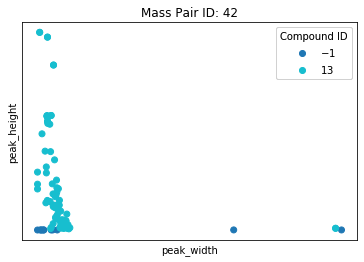

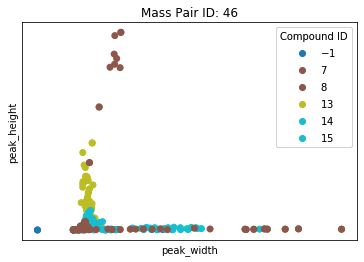

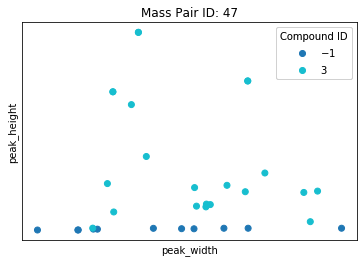

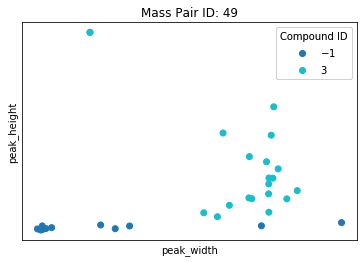

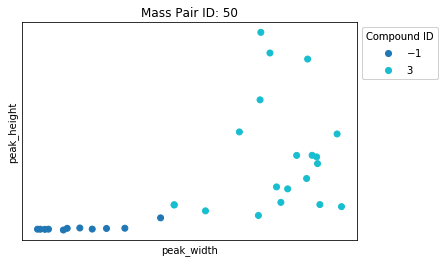

In [39]:
for mass_pair_id, compound_id_to_dataset in mass_pair_id_to_compound_ids_to_dataset.items():
    plot_with_labels(mass_pair_id, compound_id_to_dataset, ['peak_width', 'peak_height'])
    plt.show()

In most cases, graphically height looks a lot worse than position as a feature. In both cases, the features seem less than ideal. Let's apply a polynomial support vector machine to the data. My hope is to create a very general classification that combined with all the associated mass pairs we can gain good results.

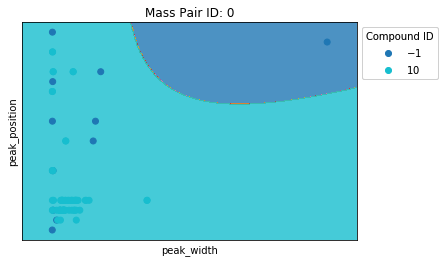

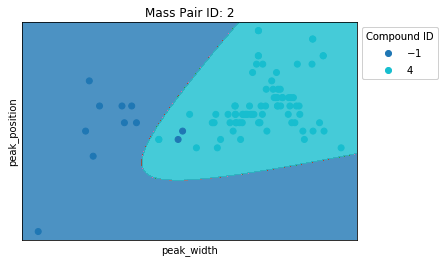

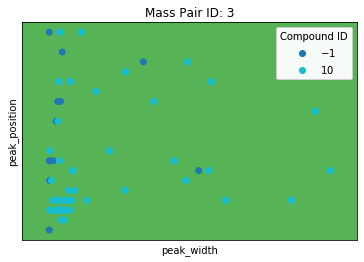

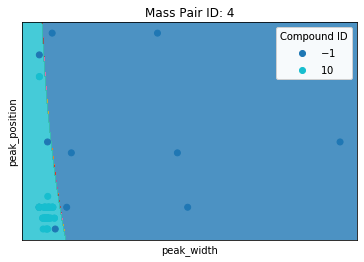

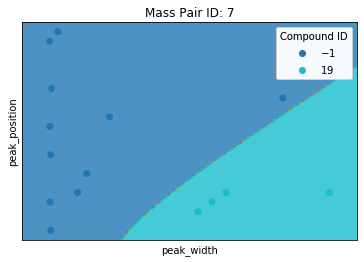

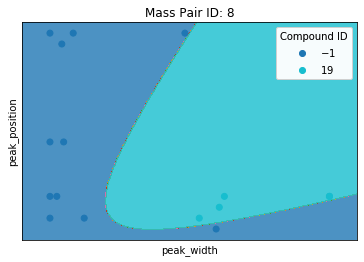

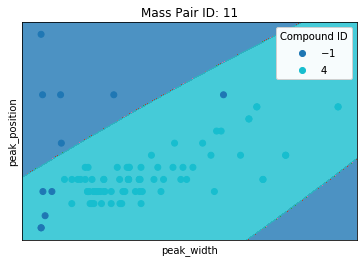

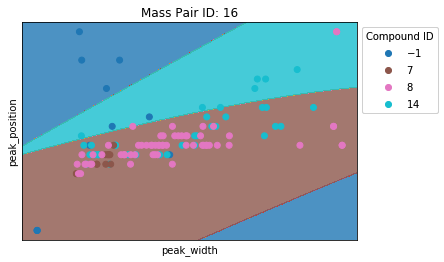

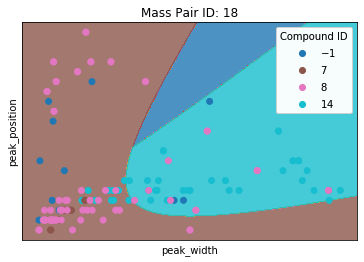

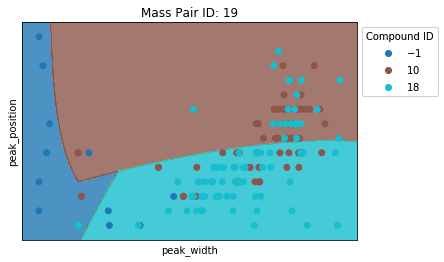

In [ ]:
from sklearn.svm import SVC
C = 1.0  # SVM regularization parameter

for mass_pair_id, compound_id_to_dataset in mass_pair_id_to_compound_ids_to_dataset.items():
    plot_with_labels(mass_pair_id, compound_id_to_dataset, ['peak_width', 'peak_position'], lambda: SVC(kernel='poly', degree=2, C=C))
    plt.show()

After reviewing each mass pair graph, it appears that in some cases we can distinguish quite well, while in other cases we cannot. Looking at mass pair id 46 we can see that the regions drawn are quite elaborate. This is very concerning because it could indicate that the current feature set we are using will now scale well if we were to expand our compound library. Peak shape may be a possible distinguisher. I will have to use a CNN on the intensities to see if they can be classified accordingly.